##### Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy import stats
from xgboost import XGBRegressor
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import warnings
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
# from graphviz import Digraph
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')

##### Visual Start

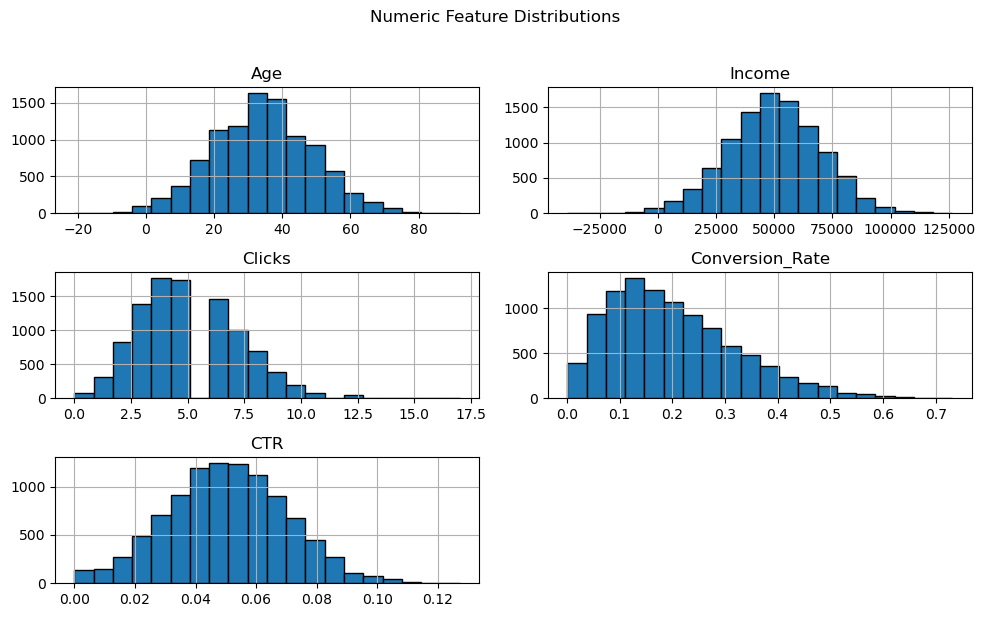

In [2]:
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

numeric_cols = ['Age', 'Income', 'Clicks', 'Conversion_Rate', 'CTR']

df[numeric_cols].hist(bins=20, figsize=(10,6), edgecolor='black')
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


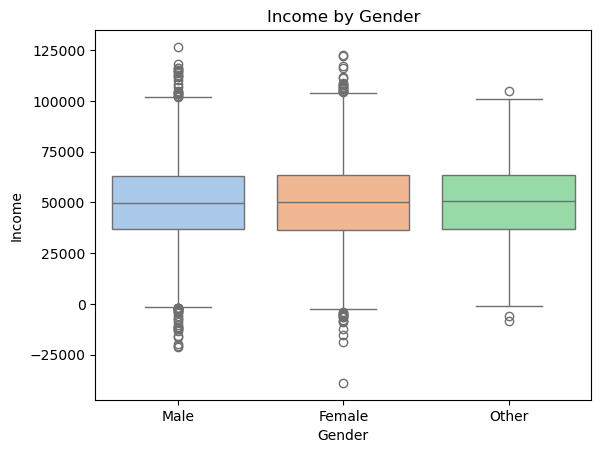

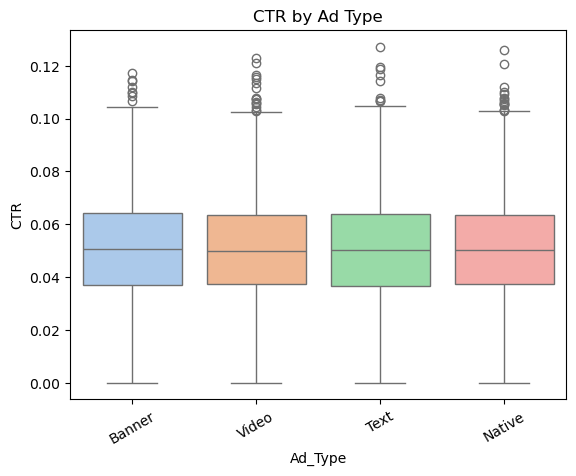

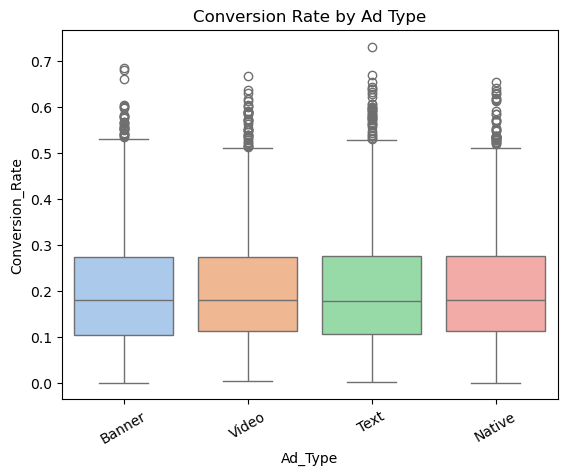

In [3]:
sns.boxplot(data=df, x='Gender', y='Income', palette='pastel')
plt.title("Income by Gender")
plt.show()

sns.boxplot(data=df, x='Ad_Type', y='CTR', palette='pastel')
plt.title("CTR by Ad Type")
plt.xticks(rotation=30)
plt.show()

sns.boxplot(data=df, x='Ad_Type', y='Conversion_Rate', palette='pastel')
plt.title("Conversion Rate by Ad Type")
plt.xticks(rotation=30)
plt.show()


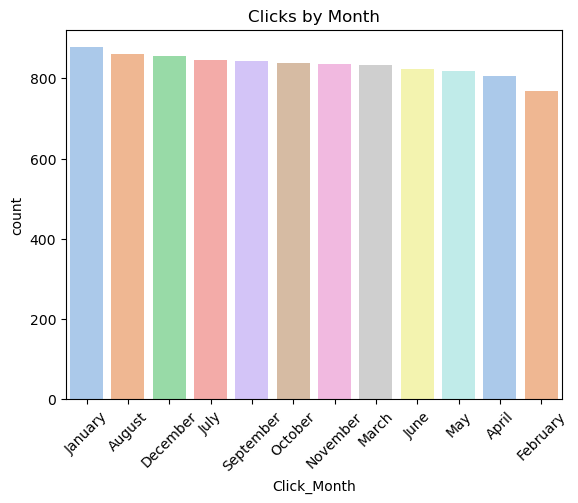

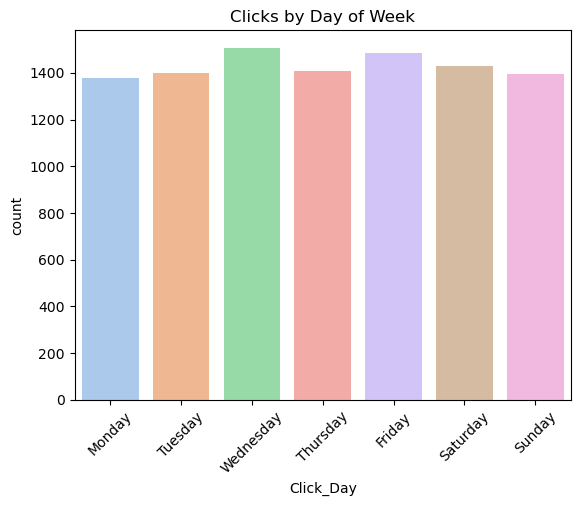

In [4]:
# I like this because now I have more time series data, and I can see when there is more clicks per month.
df['Click_Time'] = pd.to_datetime(df['Click_Time'])
df['Click_Hour'] = df['Click_Time'].dt.hour
df['Click_Month'] = df['Click_Time'].dt.month_name()
df['Click_Day'] = df['Click_Time'].dt.day_name()


sns.countplot(data=df, x='Click_Month', palette='pastel', order=df['Click_Month'].value_counts().index)
plt.title("Clicks by Month")
plt.xticks(rotation=45)
plt.show()

# # the time stamps are sort've useless because they're all only different by miliseconds...
# sns.countplot(data=df, x='Click Hour', palette='pastel', order=df['Click Hour'].value_counts().index)
# plt.title("Clicks by Month")
# plt.xticks(rotation=45)
# plt.show()

# the day it was clicked might be better actually...
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='Click_Day', palette='pastel', order=day_order)
plt.title("Clicks by Day of Week")
plt.xticks(rotation=45)
plt.show()

##### Visual End

##### Data Exploration Start

In [5]:
# Load your data
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

# Data inspection and cleaning
print("="*80)
print("DATA INSPECTION")
print("="*80)
print("\nDataset shape:", df.shape)
print("\nColumn data types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

# Convert Click Time to datetime if needed
df['Click_Time'] = pd.to_datetime(df['Click_Time'])

# Ensure numeric columns are properly typed
numeric_cols = ['Age', 'Income', 'Clicks', 'Conversion_Rate', 'CTR']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with missing values in key columns
df_clean = df.dropna(subset=numeric_cols)
print(f"\nRows after cleaning: {len(df_clean)} (dropped {len(df) - len(df_clean)} rows)")

# Create dummy variables for categorical variables
df_encoded = pd.get_dummies(df_clean, columns=['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement'], 
                             drop_first=True)

# Verify no object types remain in encoded data
print("\nEncoded data types:")
print(df_encoded.dtypes.value_counts())

print("="*80)
print("ECONOMETRIC DIAGNOSTICS ANALYSIS")
print("="*80)

# ============================================================================
# 1. ENDOGENEITY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("1. ENDOGENEITY ANALYSIS")
print("="*80)

print("\nPotential Endogeneity Issues:")
print("-" * 40)

# Check correlation between Clicks and dependent variables
print("\n1.1 Correlation Analysis (Potential Endogeneity Red Flags):")
print("-" * 40)
corr_matrix = df_clean[['Clicks', 'CTR', 'Conversion_Rate', 'Age', 'Income']].corr()
print("\nCorrelation with Clicks (potential endogenous variable):")
print(corr_matrix['Clicks'].sort_values(ascending=False))


# Test for endogeneity using Hausman-Wu test approach
print("\n1.2 Testing for Endogeneity (Hausman-Wu Test Approach):")
print("-" * 40)

# Prepare variables for Conversion Rate model
y = df_encoded['Conversion_Rate'].values
X_vars = ['Age', 'Income', 'Clicks']
X_cats = [col for col in df_encoded.columns if col.startswith(('Gender_', 'Location_', 
          'Ad Type_', 'Ad Topic_', 'Ad Placement_'))]

# Ensure all columns exist and are numeric
available_X_vars = [v for v in X_vars if v in df_encoded.columns]
available_X_cats = [c for c in X_cats if c in df_encoded.columns]

print(f"Using {len(available_X_vars)} numeric variables: {available_X_vars}")
print(f"Using {len(available_X_cats)} categorical dummy variables")

X = df_encoded[available_X_vars + available_X_cats].astype(float)
X = add_constant(X)

# Stage 1: Regress potentially endogenous variable (Clicks) on instruments + exogenous
# Using Age and Income as instruments (assuming they're exogenous)
instruments = ['Age', 'Income'] + available_X_cats
available_instruments = [i for i in instruments if i in df_encoded.columns]
X_stage1 = df_encoded[available_instruments].astype(float)
X_stage1 = add_constant(X_stage1)

try:
    model_stage1 = OLS(df_encoded['Clicks'].astype(float).values, X_stage1).fit()
    residuals_stage1 = model_stage1.resid

    # Stage 2: Include residuals in original regression
    X_with_resid = X.copy()
    X_with_resid['clicks_residual'] = residuals_stage1
    model_stage2 = OLS(y, X_with_resid).fit()

    # Test if residual coefficient is significant
    resid_pvalue = model_stage2.pvalues['clicks_residual']
    print(f"\nResidual coefficient p-value: {resid_pvalue:.4f}")
    if resid_pvalue < 0.05:
        print("✗ ENDOGENEITY DETECTED: Clicks appears to be endogenous (p < 0.05)")
        print("  Recommendation: Use Instrumental Variables (IV) regression or 2SLS")
    else:
        print("✓ No strong evidence of endogeneity in Clicks (p ≥ 0.05)")
except Exception as e:
    print(f"⚠️  Could not complete endogeneity test: {str(e)}")
    print("   This may be due to perfect multicollinearity or data issues")

# Calculate VIF for multicollinearity (related to endogeneity)
print("\n1.3 Variance Inflation Factors (VIF) - Multicollinearity Check:")
print("-" * 40)
try:
    X_vif = df_encoded[['Age', 'Income', 'Clicks']].astype(float)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print(vif_data)
    print("\nVIF > 10 suggests high multicollinearity (potential endogeneity concern)")
except Exception as e:
    print(f"⚠️  Could not calculate VIF: {str(e)}")


DATA INSPECTION

Dataset shape: (10000, 11)

Column data types:
Age                  int64
Gender              object
Income             float64
Location            object
Ad_Type             object
Ad_Topic            object
Ad_Placement        object
Clicks               int64
Click_Time          object
Conversion_Rate    float64
CTR                float64
dtype: object

First few rows:
   Age  Gender    Income  Location Ad_Type Ad_Topic   Ad_Placement  Clicks  \
0   61    Male  35717.43     Urban  Banner   Travel   Social Media       3   
1   41    Male  47453.25     Rural   Video   Travel  Search Engine       5   
2   49  Female  68126.35     Rural    Text     Food   Social Media       4   
3   68  Female  64585.73  Suburban    Text   Health        Website       6   
4   63    Male  21109.40     Urban  Native  Fashion  Search Engine       5   

                   Click_Time  Conversion_Rate     CTR  
0  2024-01-18 20:45:56.898459           0.0981  0.0737  
1  2023-04-24 20:45:56.89


2. HETEROSKEDASTICITY ANALYSIS

2.1 Breusch-Pagan Test:
----------------------------------------
LM Statistic: 3.0970
LM-Test p-value: 0.8759
F-Statistic: 0.4422
F-Test p-value: 0.8760
✓ No strong evidence of heteroskedasticity (p ≥ 0.05)

2.2 White Test:
----------------------------------------
LM Statistic: 23.4231
LM-Test p-value: 0.7568
F-Statistic: 0.8072
F-Test p-value: 0.7574
✓ No strong evidence of heteroskedasticity (p ≥ 0.05)

2.3 Visual Inspection:
----------------------------------------
Generating residual plots...


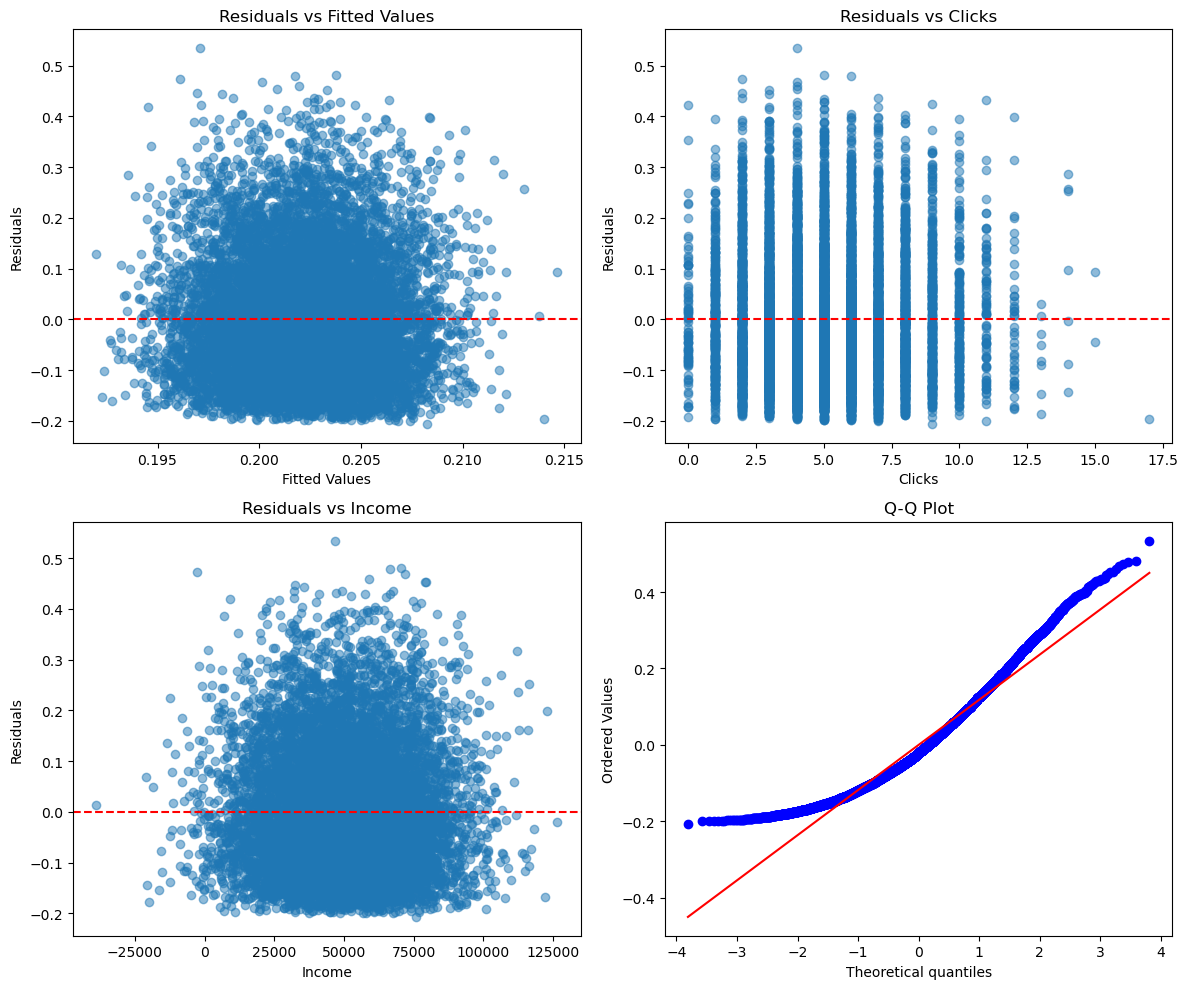

In [6]:
# ============================================================================
# 2. HETEROSKEDASTICITY TESTS
# ============================================================================
print("\n" + "="*80)
print("2. HETEROSKEDASTICITY ANALYSIS")
print("="*80)

# Run base model for heteroskedasticity tests
try:
    base_model = OLS(y, X).fit()
    
    # Breusch-Pagan Test
    print("\n2.1 Breusch-Pagan Test:")
    print("-" * 40)
    bp_test = het_breuschpagan(base_model.resid, X)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    bp_results = dict(zip(labels, bp_test))
    for key, val in bp_results.items():
        print(f"{key}: {val:.4f}")

    if bp_results['LM-Test p-value'] < 0.05:
        print("✗ HETEROSKEDASTICITY DETECTED (p < 0.05)")
        print("  Recommendation: Use robust standard errors (HC1, HC3) or WLS")
    else:
        print("✓ No strong evidence of heteroskedasticity (p ≥ 0.05)")

    # White Test
    print("\n2.2 White Test:")
    print("-" * 40)
    white_test = het_white(base_model.resid, X)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    white_results = dict(zip(labels, white_test))
    for key, val in white_results.items():
        print(f"{key}: {val:.4f}")

    if white_results['LM-Test p-value'] < 0.05:
        print("✗ HETEROSKEDASTICITY DETECTED (p < 0.05)")
    else:
        print("✓ No strong evidence of heteroskedasticity (p ≥ 0.05)")

    # Visualize residuals
    print("\n2.3 Visual Inspection:")
    print("-" * 40)
    print("Generating residual plots...")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals vs Fitted
    axes[0, 0].scatter(base_model.fittedvalues, base_model.resid, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted Values')

    # Residuals vs Clicks
    axes[0, 1].scatter(df_clean['Clicks'].values, base_model.resid, alpha=0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Clicks')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals vs Clicks')

    # Residuals vs Income
    axes[1, 0].scatter(df_clean['Income'].values, base_model.resid, alpha=0.5)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Income')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs Income')

    # Q-Q Plot
    stats.probplot(base_model.resid, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot')

    plt.tight_layout()
    # plt.savefig('heteroskedasticity_diagnostics.png', dpi=300, bbox_inches='tight')
    # print("✓ Saved: heteroskedasticity_diagnostics.png")
    
except Exception as e:
    print(f"⚠️  Could not complete heteroskedasticity tests: {str(e)}")
    bp_results = {'LM-Test p-value': None}
    white_results = {'LM-Test p-value': None}



3. AUTOCORRELATION ANALYSIS

3.1 Durbin-Watson Test:
----------------------------------------
Durbin-Watson Statistic: 2.0100

Interpretation:
  DW ≈ 2.0: No autocorrelation
  DW < 1.5: Positive autocorrelation
  DW > 2.5: Negative autocorrelation
✓ No strong evidence of autocorrelation (DW = 2.0100)

3.2 Ljung-Box Test (for higher-order autocorrelation):
----------------------------------------
     lb_stat  lb_pvalue
1   0.258970   0.610829
5   4.732977   0.449329
10  7.163398   0.709934

If p-value < 0.05, autocorrelation is present at that lag


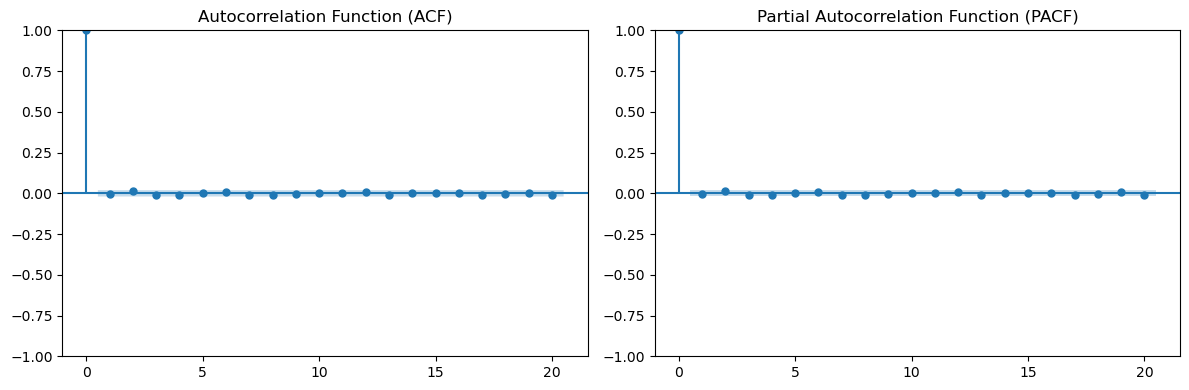

In [7]:

# ============================================================================
# 3. AUTOCORRELATION TESTS
# ============================================================================
print("\n" + "="*80)
print("3. AUTOCORRELATION ANALYSIS")
print("="*80)

# Sort by time for autocorrelation tests
df_sorted = df_clean.sort_values('Click_Time').reset_index(drop=True)
df_encoded_sorted = pd.get_dummies(df_sorted, 
                                   columns=['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement'], 
                                   drop_first=True)

y_sorted = df_encoded_sorted['Conversion_Rate'].values
available_X_cats_sorted = [col for col in df_encoded_sorted.columns if col.startswith(('Gender_', 'Location_', 
          'Ad Type_', 'Ad Topic_', 'Ad Placement_'))]
X_sorted = df_encoded_sorted[available_X_vars + available_X_cats_sorted].astype(float)
X_sorted = add_constant(X_sorted)

try:
    model_sorted = OLS(y_sorted, X_sorted).fit()

    # Durbin-Watson Test
    print("\n3.1 Durbin-Watson Test:")
    print("-" * 40)
    dw_stat = durbin_watson(model_sorted.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
    print("\nInterpretation:")
    print("  DW ≈ 2.0: No autocorrelation")
    print("  DW < 1.5: Positive autocorrelation")
    print("  DW > 2.5: Negative autocorrelation")

    if dw_stat < 1.5:
        print(f"✗ POSITIVE AUTOCORRELATION DETECTED (DW = {dw_stat:.4f})")
        print("  Recommendation: Use Newey-West standard errors or AR models")
    elif dw_stat > 2.5:
        print(f"✗ NEGATIVE AUTOCORRELATION DETECTED (DW = {dw_stat:.4f})")
    else:
        print(f"✓ No strong evidence of autocorrelation (DW = {dw_stat:.4f})")

    # Ljung-Box Test
    print("\n3.2 Ljung-Box Test (for higher-order autocorrelation):")
    print("-" * 40)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(model_sorted.resid, lags=[1, 5, 10], return_df=True)
    print(lb_test)
    print("\nIf p-value < 0.05, autocorrelation is present at that lag")

    # Autocorrelation plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ACF Plot
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plot_acf(model_sorted.resid, lags=20, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # PACF Plot
    plot_pacf(model_sorted.resid, lags=20, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    # plt.savefig('autocorrelation_diagnostics.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Saved: autocorrelation_diagnostics.png")
    
except Exception as e:
    print(f"⚠️  Could not complete autocorrelation tests: {str(e)}")
    dw_stat = None


##### Data Exploration End

##### Preprocessing Start

In [8]:
def clean_data(df):
    """
    Clean and preprocess data before analysis.
    
    Performs:
    1. Handle negative income values
    2. Impute missing income with median
    3. Winsorize income at 1st and 99th percentiles
    4. Filter age to plausible range (10-90 years)
    5. Create logarithmic transformations for skewed variables
    """
    print("\n" + "="*60)
    print("DATA CLEANING AND PREPROCESSING")
    print("="*60)
    
    initial_rows = len(df)
    
    # =====================================================================
    # 1. CLEAN INCOME
    # =====================================================================
    if 'Income' in df.columns:
        # Convert negative income to missing
        neg_income_count = (df['Income'] < 0).sum()
        df.loc[df['Income'] < 0, 'Income'] = np.nan
        
        if neg_income_count > 0:
            print(f"✓ Converted {neg_income_count} negative income values to missing")
        
        # Impute missing income with median
        missing_income = df['Income'].isna().sum()
        if missing_income > 0:
            imputer = SimpleImputer(strategy='median')
            df['Income'] = imputer.fit_transform(df[['Income']])
            print(f"✓ Imputed {missing_income} missing income values with median")
        
        # Winsorize: Cap extremes at 1st and 99th percentile
        lower, upper = df['Income'].quantile([0.01, 0.99])
        income_before = df['Income'].copy()
        df['Income'] = df['Income'].clip(lower, upper)
        winsorized = (income_before != df['Income']).sum()
        print(f"✓ Winsorized {winsorized} income values at 1st/99th percentiles")
        print(f"  Income range: [{lower:,.0f}, {upper:,.0f}]")
    
    # =====================================================================
    # 2. FILTER AGE
    # =====================================================================
    if 'Age' in df.columns:
        age_before = len(df)
        df = df[df['Age'].between(10, 90)]
        age_filtered = age_before - len(df)
        if age_filtered > 0:
            print(f"✓ Filtered {age_filtered} rows with implausible ages (keeping 10-90)")
    
    # =====================================================================
    # 3. CREATE LOGARITHMIC TRANSFORMATIONS
    # =====================================================================
    print(f"\n📊 Creating logarithmic transformations:")
    
    # Log of Income (if positive)
    if 'Income' in df.columns:
        df['Income_log'] = np.log1p(df['Income'])
        print(f"  ✓ Income_log created (log1p transformation)")
    
    # # Log of Clicks (if exists and positive)
    # if 'Clicks' in df.columns:
    #     df['Clicks_log'] = np.log1p(df['Clicks'])
    #     print(f"  ✓ Clicks_log created (log1p transformation)")
    
    # Log of Age (for nonlinear age effects)
    if 'Age' in df.columns:
        df['Age_log'] = np.log1p(df['Age'])
        print(f"  ✓ Age_log created (log1p transformation)")
    
    # # Log of CTR (if exists and positive)
    # if 'CTR' in df.columns:
    #     # Ensure CTR is positive before log
    #     if (df['CTR'] > 0).all():
    #         df['CTR_log'] = np.log(df['CTR'])
    #         print(f"  ✓ CTR_log created (log transformation)")
    
    # =====================================================================
    # SUMMARY
    # =====================================================================
    final_rows = len(df)
    rows_removed = initial_rows - final_rows
    
    print(f"\n{'='*60}")
    print(f"CLEANING SUMMARY:")
    print(f"  Initial rows:        {initial_rows:,}")
    print(f"  Final rows:          {final_rows:,}")
    print(f"  Rows removed:        {rows_removed:,} ({rows_removed/initial_rows*100:.1f}%)")
    print(f"  Log variables added: {len([col for col in df.columns if '_log' in col])}")
    print(f"{'='*60}\n")
    
    return df

    
def engineer_time_features(df):
    """Extract day of week and hour from Click_Time"""
    if 'Click_Time' in df.columns:
        df['Click_Time'] = pd.to_datetime(df['Click_Time'])
        df['Day_of_Week'] = df['Click_Time'].dt.dayofweek
        df['Hour'] = df['Click_Time'].dt.hour
    return df
    
def encode_categorical_features(df):
    """Encode categorical variables"""
    categorical_cols = ['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement']
    
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            # df[col] = le # This line was wierd, idk why it did this, but i may have to revert things back.
    
    return df

# gonna hold off on this interaction term stuff for now.
def engineer_instrument_features(df):
    """
    ENHANCED: Create rich features that predict clicks but don't directly affect conversions.
    
    This is crucial for instrument strength. We create:
    1. Interaction features between ad characteristics and demographics
    2. Time-based features (weekend, business hours)
    3. Nonlinear transformations
    4. Complex interactions between multiple variables
    
    Key principle: These features should predict CLICKS well, but only affect
    CONVERSIONS through clicks (exclusion restriction).
    """
    print("\n" + "="*60)
    print("FEATURE ENGINEERING FOR INSTRUMENT STRENGTH")
    print("="*60)
    
    # =====================================================================
    # 1. AD CHARACTERISTICS × DEMOGRAPHICS INTERACTIONS
    # =====================================================================
    # Rationale: Different demographics respond differently to ad types
    
    if all(col in df.columns for col in ['Income', 'Ad_Type_encoded']):
        df['Income_x_AdType'] = df['Income'] * df['Ad_Type_encoded']
        print("✓ Created Income × Ad Type interaction")
        
    if all(col in df.columns for col in ['Age', 'Ad_Topic_encoded']):
        df['Age_x_AdTopic'] = df['Age'] * df['Ad_Topic_encoded']
        print("✓ Created Age × Ad Topic interaction")
        
    if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded']):
        df['Income_x_Placement'] = df['Income'] * df['Ad_Placement_encoded']
        print("✓ Created Income × Ad Placement interaction")
        
    if all(col in df.columns for col in ['Age', 'Ad_Placement_encoded']):
        df['Age_x_Placement'] = df['Age'] * df['Ad_Placement_encoded']
        print("✓ Created Age × Ad Placement interaction")
    
    # =====================================================================
    # 2. TIME-BASED FEATURES AND INTERACTIONS
    # =====================================================================
    # Rationale: Click patterns vary by time of day/week
    
    if 'Day_of_Week' in df.columns:
        df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)
        print("✓ Created Weekend indicator")
        
    if 'Hour' in df.columns:
        df['BusinessHours'] = ((df['Hour'] >= 9) & (df['Hour'] <= 17)).astype(int)
        df['Evening'] = ((df['Hour'] >= 18) & (df['Hour'] <= 23)).astype(int)
        df['Morning'] = ((df['Hour'] >= 6) & (df['Hour'] <= 11)).astype(int)
        print("✓ Created time-of-day indicators")
    
    # Time × Ad interactions
    if all(col in df.columns for col in ['Weekend', 'Ad_Type_encoded']):
        df['Weekend_x_AdType'] = df['Weekend'] * df['Ad_Type_encoded']
        print("✓ Created Weekend × Ad Type interaction")
        
    if all(col in df.columns for col in ['BusinessHours', 'Ad_Placement_encoded']):
        df['BusinessHours_x_Placement'] = df['BusinessHours'] * df['Ad_Placement_encoded']
        print("✓ Created Business Hours × Ad Placement interaction")
        
    if all(col in df.columns for col in ['Evening', 'Ad_Topic_encoded']):
        df['Evening_x_AdTopic'] = df['Evening'] * df['Ad_Topic_encoded']
        print("✓ Created Evening × Ad Topic interaction")
    
    # =====================================================================
    # 3. DEMOGRAPHICS × TIME INTERACTIONS
    # =====================================================================
    # Rationale: Different demographics have different browsing patterns
    
    if all(col in df.columns for col in ['Age', 'Hour']):
        df['Age_x_Hour'] = df['Age'] * df['Hour']
        print("✓ Created Age × Hour interaction")
        
    if all(col in df.columns for col in ['Income', 'Weekend']):
        df['Income_x_Weekend'] = df['Income'] * df['Weekend']
        print("✓ Created Income × Weekend interaction")
        
    if all(col in df.columns for col in ['Age', 'BusinessHours']):
        df['Age_x_BusinessHours'] = df['Age'] * df['BusinessHours']
        print("✓ Created Age × Business Hours interaction")
    
    # =====================================================================
    # 4. NONLINEAR TRANSFORMATIONS
    # =====================================================================
    # Rationale: Relationships may be nonlinear (using log-transformed versions)
    
    if 'Age_log' in df.columns:
        df['Age_squared'] = df['Age'] ** 2
        print("✓ Created Age squared")
        
    if 'Income_log' in df.columns:
        df['Income_squared'] = df['Income'] ** 2
        df['Income_sqrt'] = np.sqrt(df['Income'].clip(lower=0))
        print("✓ Created Income squared and sqrt")
    
    # =====================================================================
    # 5. COMPLEX CATEGORICAL INTERACTIONS
    # =====================================================================
    # Rationale: Certain combinations may be particularly predictive
    
    # Location × Demographics
    if all(col in df.columns for col in ['Location_encoded', 'Age']):
        df['Location_x_Age'] = df['Location_encoded'] * df['Age']
        print("✓ Created Location × Age interaction")
        
    if all(col in df.columns for col in ['Location_encoded', 'Income']):
        df['Location_x_Income'] = df['Location_encoded'] * df['Income']
        print("✓ Created Location × Income interaction")
    
    # Location × Ad characteristics
    if all(col in df.columns for col in ['Location_encoded', 'Ad_Placement_encoded']):
        df['Location_x_Placement'] = df['Location_encoded'] * df['Ad_Placement_encoded']
        print("✓ Created Location × Placement interaction")
    
    # Gender × Ad characteristics
    if all(col in df.columns for col in ['Gender_encoded', 'Ad_Topic_encoded']):
        df['Gender_x_AdTopic'] = df['Gender_encoded'] * df['Ad_Topic_encoded']
        print("✓ Created Gender × Ad Topic interaction")
        
    if all(col in df.columns for col in ['Gender_encoded', 'Ad_Type_encoded']):
        df['Gender_x_AdType'] = df['Gender_encoded'] * df['Ad_Type_encoded']
        print("✓ Created Gender × Ad Type interaction")
    
    # Ad Type × Placement (different placements work for different types)
    if all(col in df.columns for col in ['Ad_Type_encoded', 'Ad_Placement_encoded']):
        df['AdType_x_Placement'] = df['Ad_Type_encoded'] * df['Ad_Placement_encoded']
        print("✓ Created Ad Type × Placement interaction")
    
    # =====================================================================
    # 6. THREE-WAY INTERACTIONS (most powerful)
    # =====================================================================
    # Rationale: Capture complex patterns
    
    if all(col in df.columns for col in ['Age', 'Ad_Type_encoded', 'Weekend']):
        df['Age_x_AdType_x_Weekend'] = df['Age'] * df['Ad_Type_encoded'] * df['Weekend']
        print("✓ Created Age × Ad Type × Weekend interaction")
        
    if all(col in df.columns for col in ['Income', 'Ad_Placement_encoded', 'BusinessHours']):
        df['Income_x_Placement_x_BizHours'] = df['Income'] * df['Ad_Placement_encoded'] * df['BusinessHours']
        print("✓ Created Income × Placement × Business Hours interaction")
    
    print("="*60 + "\n")
    
    return df

##### Preprocessing End

##### Create ML Instrument Start

In [9]:
def create_ml_instrument(df, model_type='stacking', cv_folds=5, use_enhanced_features=False):
    """
    Generate ML-based instrument for Clicks using ensemble methods.
    Returns a new DataFrame with 'Clicks_predicted' column.
    """

    # --- Step 1: Define instrument features (strictly policy-side, not outcomes!) ---
    base_features = [
        'Age', 'Income',
        'Gender_encoded', 'Location_encoded',
        'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
        'Day_of_Week', 'Hour'
    ]

    enhanced_features = [
        # Interactions
        'Income_x_AdType', 'Age_x_AdTopic', 'Income_x_Placement', 'Age_x_Placement',
        'Weekend_x_AdType', 'BusinessHours_x_Placement', 'Evening_x_AdTopic',
        'Age_x_Hour', 'Income_x_Weekend', 'Age_x_BusinessHours',
        'Location_x_Age', 'Location_x_Income', 'Location_x_Placement',
        'Gender_x_AdTopic', 'Gender_x_AdType', 'AdType_x_Placement',
        'Age_x_AdType_x_Weekend', 'Income_x_Placement_x_BizHours',
        # Time features
        'Weekend', 'BusinessHours', 'Evening', 'Morning',
        # Nonlinear (now using cleaned log versions) NOTE only created if i log age, and income...
        'Age_squared', 'Age_log', 'Income_log', 'Income_squared', 'Income_sqrt'
    ]

    # Keeping this since this was how many interaction terms I tried to feature engineer but it failed so bad.
    # NOTE advanced_enhanced features, but is name to enhanced_features for ease of use.
    # enhanced_features = [
    #     'Income_log', 'Age_log', 'Month', 'Day_of_Month', 'Week_of_Year', 
    #     'Weekend', 'BusinessHours', 
    #     'Evening', 'Morning', 'Night', 'Lunch', 'Is_Summer', 'Is_Winter', 'Is_Holiday_Season', 'Beginning_of_Month', 'End_of_Month', 
    #     'Is_Monday', 'Is_Friday',
    #     'Age_x_Ad_Type_encoded', 'Age_x_Ad_Topic_encoded', 'Age_x_Ad_Placement_encoded', 'Income_x_Ad_Type_encoded', 
    #     'Income_x_Ad_Topic_encoded', 'Income_x_Ad_Placement_encoded', 'Gender_encoded_x_Ad_Type_encoded', 
    #     'Gender_encoded_x_Ad_Topic_encoded', 'Gender_encoded_x_Ad_Placement_encoded', 'Age_x_Weekend', 'Age_x_BusinessHours', 
    #     'Age_x_Evening', 'Age_x_Morning', 'Age_x_Hour', 'Age_x_Is_Monday', 'Age_x_Is_Friday', 'Age_x_Beginning_of_Month', 
    #     'Age_x_End_of_Month', 'Income_x_Weekend', 'Income_x_BusinessHours', 'Income_x_Evening', 'Income_x_Morning', 'Income_x_Hour', 
    #     'Income_x_Is_Monday', 'Income_x_Is_Friday', 'Income_x_Beginning_of_Month', 'Income_x_End_of_Month', 'Ad_Type_encoded_x_Weekend', 
    #     'Ad_Type_encoded_x_BusinessHours', 'Ad_Type_encoded_x_Evening', 'Ad_Type_encoded_x_Morning', 'Ad_Type_encoded_x_Hour', 
    #     'Ad_Type_encoded_x_Is_Monday', 'Ad_Type_encoded_x_Is_Friday', 'Ad_Type_encoded_x_Beginning_of_Month', 
    #     'Ad_Type_encoded_x_End_of_Month', 'Ad_Topic_encoded_x_Weekend', 'Ad_Topic_encoded_x_BusinessHours', 
    #     'Ad_Topic_encoded_x_Evening', 'Ad_Topic_encoded_x_Morning', 'Ad_Topic_encoded_x_Hour', 'Ad_Topic_encoded_x_Is_Monday', 
    #     'Ad_Topic_encoded_x_Is_Friday', 'Ad_Topic_encoded_x_Beginning_of_Month', 'Ad_Topic_encoded_x_End_of_Month', 
    #     'Ad_Placement_encoded_x_Weekend', 'Ad_Placement_encoded_x_BusinessHours', 'Ad_Placement_encoded_x_Evening', 
    #     'Ad_Placement_encoded_x_Morning', 'Ad_Placement_encoded_x_Hour', 'Ad_Placement_encoded_x_Is_Monday', 
    #     'Ad_Placement_encoded_x_Is_Friday', 'Ad_Placement_encoded_x_Beginning_of_Month', 'Ad_Placement_encoded_x_End_of_Month', 
    #     'Location_x_Age', 'Location_x_Income', 'Location_x_Gender_encoded', 'Location_x_Ad_Type_encoded', 'Location_x_Ad_Topic_encoded',
    #     'Location_x_Ad_Placement_encoded', 'Location_x_Weekend', 'Location_x_BusinessHours', 'Location_x_Evening', 'Age_squared', 
    #     'Age_cubed', 'Age_sqrt', 'Income_squared', 'Income_sqrt', 'Hour_squared', 'Hour_sin', 'Hour_cos', 'Age_x_AdType_x_Weekend', 
    #     'Age_x_AdType_x_Evening', 'Income_x_Placement_x_BizHours', 'Income_x_Placement_x_Weekend',
    #     'Location_x_AdType_x_Evening', 'Gender_x_Topic_x_Weekend', 'AdType_x_Placement', 'AdType_x_Topic', 'AdTopic_x_Placement'
    # ]
    
    if use_enhanced_features:
        # Assume you have a separate function to engineer features
        df = engineer_instrument_features(df)
        # df = engineer_instrument_features_comprehensive(df)

        instrument_features = base_features + enhanced_features
    else:
        instrument_features = base_features

    # Filter available features
    available_features = [f for f in instrument_features if f in df.columns]
    # print('\n FLAG', available_features)
    # print(df.describe(include='all'))
    print(df.dtypes)

    X = df[available_features]
    y = df['Clicks']

    # --- Step 2: Build model ---
    if model_type == 'stacking':
        base_models = [
            ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
            ('gb', GradientBoostingRegressor(n_estimators=200, random_state=42))
        ]
        try:
            from xgboost import XGBRegressor
            base_models.append(('xgb', XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)))
        except ImportError:
            pass
        model = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1.0), cv=cv_folds, n_jobs=-1)

    elif model_type == 'rf':
        model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

    elif model_type == 'gb':
        model = GradientBoostingRegressor(n_estimators=200, random_state=42)

    else:
        raise ValueError("Invalid model_type. Choose 'stacking', 'rf', or 'gb'.")

    # --- Step 3: Generate out-of-fold predictions ---
    clicks_pred = cross_val_predict(model, X, y, cv=cv_folds, n_jobs=-1)
    df = df.copy()
    df['Clicks_predicted'] = clicks_pred

    # --- Step 4: Fit final model (optional, for diagnostics) ---
    model.fit(X, y)

    return df, X, model

def enhanced_instrument_diagnostics(df, X, y, model):
    """
    Functional: Comprehensive instrument strength testing with Stock-Yogo critical values.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Clicks' and 'Clicks_predicted' columns.
    X : pd.DataFrame
        Feature matrix used in first-stage model.
    y : pd.Series or np.array
        True clicks (endogenous regressor).
    model : fitted sklearn model
        First-stage ML model used to generate instruments.
    """

    # --- Extract instrument (Z) and endogenous regressor (D) ---
    if 'Clicks_predicted' not in df.columns:
        raise ValueError("DataFrame must contain 'Clicks_predicted' column")
    z = df['Clicks_predicted'].values
    d = df['Clicks'].values

    n = len(d)
    k = X.shape[1]

    # --- First-stage R² and F-statistic ---
    d_resid = d - d.mean()
    ss_tot = np.sum(d_resid**2)
    ss_res = np.sum((d - z)**2)
    r_squared = 1 - (ss_res / ss_tot)

    f_stat = (r_squared / 1) / ((1 - r_squared) / (n - k - 1))

    # --- Correlation ---
    corr = np.corrcoef(z, d)[0, 1]

    # --- Cragg-Donald statistic ---
    cragg_donald = n * r_squared

    # --- Display results ---
    print(f"\n{'='*70}")
    print("ENHANCED INSTRUMENT STRENGTH DIAGNOSTICS")
    print(f"{'='*70}")
    print("\nSAMPLE INFORMATION:")
    print(f"  Sample size (n):              {n:,}")
    print(f"  Number of features (k):       {k}")
    print("\nFIRST-STAGE PERFORMANCE:")
    print(f"  R-squared:                    {r_squared:.4f}")
    print(f"  Correlation (Z, D):           {corr:.4f}")
    print(f"  F-statistic:                  {f_stat:.2f}")
    print(f"  Cragg-Donald statistic:       {cragg_donald:.2f}")

    print("\nBENCHMARKS & INTERPRETATION:")
    print(f"  {'Criterion':<35} {'Threshold':<12} {'Status'}")
    print(f"  {'-'*35} {'-'*12} {'-'*20}")
    weak_status = "✓ STRONG" if f_stat > 10 else "✗ WEAK"
    print(f"  {'Weak Instrument (F < 10)':<35} {'10.00':<12} {weak_status}")
    sy_10_status = "✓✓ EXCELLENT" if f_stat > 16.38 else "✗ Below threshold"
    sy_15_status = "✓ GOOD" if f_stat > 8.96 else "✗ Below threshold"
    print(f"  {'Stock-Yogo 10% max bias':<35} {'16.38':<12} {sy_10_status}")
    print(f"  {'Stock-Yogo 15% max bias':<35} {'8.96':<12} {sy_15_status}")

    print("\nOVERALL ASSESSMENT:")
    if f_stat > 16.38:
        print("  ✓✓ VERY STRONG INSTRUMENT")
        print("     Maximum IV bias < 10% of OLS bias")
    elif f_stat > 10:
        print("  ✓ STRONG INSTRUMENT")
        print("     Acceptable for causal inference")
    elif f_stat > 5:
        print("  ⚠ MODERATELY WEAK INSTRUMENT")
        print("     Proceed with caution")
    else:
        print("  ✗ WEAK INSTRUMENT")
        print("     Results may be unreliable")

    # --- Feature importance (if available) ---
    if hasattr(model, 'feature_importances_'):
        print("\nTOP 10 MOST IMPORTANT FEATURES FOR PREDICTING CLICKS:")
        importances = model.feature_importances_
        top_features = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)[:10]
        for i, (feat, imp) in enumerate(top_features, 1):
            print(f"  {i:2d}. {feat:35s} {imp:.4f}")
    elif hasattr(model, 'final_estimator_'):
        print("\nℹ Stacking ensemble used - feature importances not directly available")

    print(f"{'='*70}\n")

    

##### Create ML Instrument End

##### OLS Start

In [10]:
def run_ols(
    df,
    y_col='Conversion_Rate',
    d_col='Clicks',
    base_controls=None,
    include_interactions=False,
    add_constant=True,
    cluster_col=None,
    cov_type='robust'  # 'robust' for HC, or 'cluster' if cluster_col is set
):
    """
    Naïve OLS regression treating Clicks as exogenous.
    Model:
        Y = α + β D + Θ X + ε

    Parameters
    ----------
    df : pd.DataFrame
        Must contain y_col, d_col, and any control columns.
    y_col : str
        Outcome column (e.g., 'Conversion_Rate').
    d_col : str
        Regressor (treated as exogenous here).
    base_controls : list[str] or None
        Exogenous controls.
    include_interactions : bool
        If True, include Ad_Type × Ad_Placement interaction (exogenous).
    add_constant : bool
        If True, add a constant term automatically.
    cluster_col : str or None
        Column name for cluster-robust SEs.
    cov_type : str
        'robust' (HC), 'cluster' (requires cluster_col), or 'unadjusted'.

    Returns
    -------
    results : RegressionResults
        Fitted OLS results object from statsmodels.
    data_used : pd.DataFrame
        DataFrame with columns actually used in estimation.
    """

    # --- Controls ---
    if base_controls is None:
        base_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded'
        ]

    invalid_controls = [c for c in base_controls if c not in df.columns]
    if invalid_controls:
        print(f"⚠ Skipping missing controls: {invalid_controls}")
    controls = [c for c in base_controls if c in df.columns]

    # --- Optional interaction ---
    if include_interactions:
        if ('Ad_Type_encoded' in df.columns) and ('Ad_Placement_encoded' in df.columns):
            interaction_col = 'Ad_Type_x_Placement'
            if interaction_col not in df.columns:
                df = df.copy()
                df[interaction_col] = df['Ad_Type_encoded'] * df['Ad_Placement_encoded']
                print("✓ Added exogenous interaction: Ad_Type_x_Placement")
            controls.append(interaction_col)

    # --- Build data ---
    cols_needed = [y_col, d_col] + controls
    data = df[cols_needed].dropna().copy()
    if data.empty:
        raise ValueError("After dropping NA, no rows remain for estimation.")

    y = data[y_col]
    X = data[[d_col] + controls]

    if add_constant:
        X = sm.add_constant(X)

    # --- Fit OLS ---
    if cov_type == 'cluster' and (cluster_col is not None) and (cluster_col in df.columns):
        clusters = df.loc[data.index, cluster_col]
        results = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': clusters})
    else:
        if cov_type == 'cluster' and cluster_col is None:
            print("⚠ cov_type='cluster' requested but no cluster_col provided; defaulting to robust.")
            cov_type = 'robust'
        results = sm.OLS(y, X).fit(cov_type='HC1' if cov_type == 'robust' else 'nonrobust')

    # --- Predictions ---
    data['CR_pred_OLS'] = results.predict(X)

    # --- Reporting ---
    print("\n" + "="*70)
    print("OLS ESTIMATION SUMMARY (statsmodels.api.OLS)")
    print("="*70)
    print(results.summary())

    return results, data


##### OLS End

##### 2SLS Start

In [11]:
def run_2sls(
    df,
    y_col='Conversion_Rate',
    d_col='Clicks',
    z_col='Clicks_predicted',
    base_controls=None,
    include_interactions=False,
    add_constant=True,
    cluster_col=None,
    cov_type='robust'  # 'robust' for HC, or 'cluster' if cluster_col is set
):
    """
    Functional 2SLS using linearmodels.iv.IV2SLS.

    Model:
        First stage: D = π0 + π1 Z + Γ X + ν
        Second stage: Y = α + β D + Θ X + ε

    Parameters
    ----------
    df : pd.DataFrame
        Must contain y_col, d_col, z_col, and any control columns.
    y_col : str
        Outcome column (e.g., 'Conversion_Rate').
    d_col : str
        Endogenous regressor (e.g., 'Clicks').
    z_col : str
        Instrument column (e.g., 'Clicks_predicted' from ML first stage).
    base_controls : list[str] or None
        Exogenous controls. Do NOT include outcome-adjacent variables like CTR.
        Recommended: ['Age', 'Income', 'Gender_encoded', 'Location_encoded',
                      'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded'].
    include_interactions : bool
        If True, include Ad_Type × Ad_Placement interaction (exogenous).
    add_constant : bool
        If True, add a constant term automatically.
    cluster_col : str or None
        Column name for cluster-robust SEs (e.g., 'UserID', 'CampaignID').
    cov_type : str
        'robust' (HC), 'cluster' (requires cluster_col), or 'unadjusted'.

    Returns
    -------
    results : IV2SLSResults
        Fitted IV results object from linearmodels.
    data_used : pd.DataFrame
        DataFrame with columns actually used in estimation.
    """

    # --- Validate required columns ---
    required = [y_col, d_col, z_col]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # --- Controls: enforce exogeneity discipline ---
    if base_controls is None:
        base_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded'
        ]

    # Strict: exclude CTR or any post-click/outcome-adjacent metrics from controls
    invalid_controls = [c for c in base_controls if c not in df.columns]
    if invalid_controls:
        # Warn strictly but proceed with available subset
        print(f"⚠ Skipping missing controls: {invalid_controls}")
    controls = [c for c in base_controls if c in df.columns]

    # --- Optional exogenous interaction ---
    interaction_col = None
    if include_interactions:
        if ('Ad_Type_encoded' in df.columns) and ('Ad_Placement_encoded' in df.columns):
            interaction_col = 'Ad_Type_x_Placement'
            if interaction_col not in df.columns:
                df = df.copy()
                df[interaction_col] = df['Ad_Type_encoded'] * df['Ad_Placement_encoded']
                print("✓ Added exogenous interaction: Ad_Type_x_Placement")
            controls.append(interaction_col)
        else:
            print("⚠ Interaction requested but required columns not present; skipping.")

    # --- Build data frame used in estimation ---
    cols_needed = [y_col, d_col, z_col] + controls
    data = df[cols_needed].dropna().copy()
    if data.empty:
        raise ValueError("After dropping NA, no rows remain for estimation.")

    # --- Build formula for IV2SLS ---
    # dependent ~ exog + [endog ~ instruments]
    exog_formula = ' + '.join(controls) if controls else '1'
    if add_constant and exog_formula != '1':
        exog_formula = '1 + ' + exog_formula  # linearmodels adds constant via '1 +'
    elif add_constant and exog_formula == '1':
        # '1' already denotes constant in linearmodels formula
        pass
    else:
        # No constant: use '-1' to suppress intercept if you have exog terms
        if controls:
            exog_formula = '-1 + ' + ' + '.join(controls)

    formula = f"{y_col} ~ {exog_formula} + [{d_col} ~ {z_col}]"

    # --- Fit IV2SLS ---
    if cov_type == 'cluster' and (cluster_col is not None) and (cluster_col in df.columns):
        clusters = df.loc[data.index, cluster_col]
        results = IV2SLS.from_formula(formula, data=data).fit(cov_type='clustered', clusters=clusters)
    else:
        if cov_type == 'cluster' and cluster_col is None:
            print("⚠ cov_type='cluster' requested but no cluster_col provided; defaulting to robust.")
        results = IV2SLS.from_formula(formula, data=data).fit(cov_type='robust' if cov_type != 'unadjusted' else 'unadjusted')

    # --- Predictions ---
    data['CR_pred_2SLS'] = results.fitted_values

    # --- Strict reporting ---
    print("\n" + "="*70)
    print("2SLS ESTIMATION SUMMARY (linearmodels.iv.IV2SLS)")
    print("="*70)
    print(results.summary)

    # Optional first-stage diagnostics available via .first_stage (dict of RegressionResults)
    # Example:
    try:
        fs = results.first_stage[d_col]
        print("\nFirst-stage summary (endogenous regressor: {}):".format(d_col))
        print(f"  R-squared: {fs.rsquared:.4f}")
        print(f"  F-statistic (excluded instrument): {getattr(fs, 'f_statistic', None)}")
    except Exception:
        pass

    return results, data

##### 2SLS End

In [12]:
def generate_example_data(n=1000):
    """Generate synthetic data with stronger endogeneity and valid instruments"""
    np.random.seed(42)
    
    data = pd.DataFrame({
        'Age': np.random.randint(8, 85, n),
        'Gender': np.random.choice(['M', 'F'], n),
        'Income': np.random.randint(30000, 150000, n) / 100000,  # normalized
        'Location': np.random.choice(['Urban', 'Suburban', 'Rural'], n),
        'Ad_Type': np.random.choice(['Video', 'Banner', 'Native'], n),
        'Ad_Placement': np.random.choice(['Social_Media', 'Search', 'Display'], n),
        'Ad_Topic': np.random.choice([
            'Technology', 'Fashion', 'Food', 'Travel', 
            'Finance', 'Health', 'Entertainment', 'Sports'
        ], n),
    })
    
    # Generate Click_Time (time of day in 24-hour format)
    # Biased toward certain hours (9am-11pm are more common)
    hour_weights = np.array([
        0.3, 0.2, 0.1, 0.1, 0.2, 0.4,  # 0-5 (late night/early morning - low)
        0.6, 1.0, 1.5, 2.0, 2.2, 2.0,  # 6-11 (morning - increasing)
        2.5, 2.3, 2.0, 1.8, 1.5, 1.8,  # 12-17 (afternoon - high)
        2.2, 2.5, 2.8, 2.5, 1.5, 0.8   # 18-23 (evening - peak then declining)
    ])
    hour_weights = hour_weights / hour_weights.sum()
    
    hours = np.random.choice(range(24), size=n, p=hour_weights)
    minutes = np.random.randint(0, 60, n)
    data['Click_Time'] = hours + minutes / 60.0  # Decimal hours (e.g., 14.5 = 2:30 PM)
    
    # Strong unobserved confounder
    unobserved_confounder = np.random.randn(n)
    
    # Instrument: Ad_Type × Ad_Placement (exogenous, not in error term)
    instrument_strength = (
        1.0 * (data['Ad_Type'] == 'Video').astype(float)
        + 1.0 * (data['Ad_Placement'] == 'Social_Media').astype(float)
    )
    
    # Endogenous regressor: Clicks
    # Add some influence from Ad_Topic and Click_Time (but keep them weak)
    topic_effect = (
        0.3 * (data['Ad_Topic'] == 'Technology').astype(float)
        + 0.2 * (data['Ad_Topic'] == 'Entertainment').astype(float)
    )
    
    # Peak hours (9am-9pm) get slight boost
    time_effect = 0.2 * ((data['Click_Time'] >= 9) & (data['Click_Time'] <= 21)).astype(float)
    
    clicks_base = (
        0.5
        + 0.01 * data['Age']
        + 0.2 * data['Income']
        + 2.0 * instrument_strength          # instrument drives clicks strongly
        + topic_effect                        # weak effect from topic
        + time_effect                         # weak effect from time
        + 2.0 * unobserved_confounder        # confounder dominates
        + np.random.randn(n) * 0.3
    )
    data['Clicks'] = np.clip(clicks_base, 0.1, 10)
    
    # CTR decoupled from clicks (so OLS can't lean on it as proxy)
    data['CTR'] = np.random.uniform(0.05, 0.15, n)
    
    # Conversion rate: true causal effect(.08) + confounding 
    epsilon = 0.8 * unobserved_confounder + np.random.randn(n) * 0.05
    conversion_base = (
        0.05
        + 0.08 * data['Clicks']        # true causal effect NOTE important value.
        + 0.02 * data['Income']
        + 0.005 * data['Age']
        + 0.3 * data['CTR']
        + epsilon                      # endogeneity
    )
    data['Conversion_Rate'] = np.clip(conversion_base, 0.01, 0.95)
    
    return data


##### Start of Implementation

In [13]:
# Cleaning and preprocessing
# df = pd.read_csv('../datasets/project/Dataset_Ads.csv')
df = generate_example_data(n=5000)
print("\n" + "="*60)
print('ORIGINAL DATASET')
print("="*60)
print(df.head())
print(df.describe(include='all'))

df = clean_data(df)
print("\n" + "="*60)
print('CLEANED AND LOGGED DATASET')
print("="*60)
print(df.head())

df = engineer_time_features(df)
print("\n" + "="*60)
print('TIME ENGINEERED COLUMN')
print("="*60)
print(df.head())

df = encode_categorical_features(df)
print("\n" + "="*60)
print('ENCODED CATEGORICAL VARIABLES')
print("="*60)
print(df.head())

print("\n" + "="*60)
print('DESCRIPTION OF DF AFTER PREPROCESSING')
print("="*60)
print(df.describe(include='all'))


ORIGINAL DATASET
   Age Gender   Income  Location Ad_Type Ad_Placement       Ad_Topic  \
0   59      M  0.84412     Rural  Banner       Search         Travel   
1   22      F  0.90561     Rural   Video       Search         Health   
2   79      M  1.07224  Suburban  Native       Search  Entertainment   
3   68      F  0.34409     Rural  Native      Display         Travel   
4   28      M  1.01319  Suburban   Video       Search  Entertainment   

   Click_Time    Clicks       CTR  Conversion_Rate  
0   19.000000  0.100000  0.096046         0.010000  
1    7.366667  3.383052  0.085505         0.785039  
2    6.466667  1.304174  0.131589         0.643625  
3    8.666667  2.816561  0.093031         0.950000  
4    8.666667  2.363033  0.141297         0.136113  
                Age Gender       Income  Location Ad_Type Ad_Placement  \
count   5000.000000   5000  5000.000000      5000    5000         5000   
unique          NaN      2          NaN         3       3            3   
top      

In [14]:
# ML instrument creation took about 1m40secs with real data
# ML instrument creation took about 3m8secs with synthetic data
# ML instrument creation took about 5m40secs with real data
# with advanced instrument variables it took 11m51secs and still has a very bad score.
print("\n" + "="*60)
print('CREATING ML INSTRUMENT')
print("="*60)
df, X, model = create_ml_instrument(df, model_type='stacking', use_enhanced_features=True)
# NOTE Remember that the instrument is really weak when created not using the interaction terms.


CREATING ML INSTRUMENT

FEATURE ENGINEERING FOR INSTRUMENT STRENGTH
✓ Created Income × Ad Type interaction
✓ Created Age × Ad Topic interaction
✓ Created Income × Ad Placement interaction
✓ Created Age × Ad Placement interaction
✓ Created Weekend indicator
✓ Created time-of-day indicators
✓ Created Weekend × Ad Type interaction
✓ Created Business Hours × Ad Placement interaction
✓ Created Evening × Ad Topic interaction
✓ Created Age × Hour interaction
✓ Created Income × Weekend interaction
✓ Created Age × Business Hours interaction
✓ Created Age squared
✓ Created Income squared and sqrt
✓ Created Location × Age interaction
✓ Created Location × Income interaction
✓ Created Location × Placement interaction
✓ Created Gender × Ad Topic interaction
✓ Created Gender × Ad Type interaction
✓ Created Ad Type × Placement interaction
✓ Created Age × Ad Type × Weekend interaction
✓ Created Income × Placement × Business Hours interaction

Age                                       int32
Gender     

In [15]:
# diagnostics for ml (complex) instrument strength
print("\n" + "="*60)
print('ML INSTRUMENT DIAGNOSTICS')
print("="*60)
enhanced_instrument_diagnostics(df, X, df['Clicks'], model)


ML INSTRUMENT DIAGNOSTICS

ENHANCED INSTRUMENT STRENGTH DIAGNOSTICS

SAMPLE INFORMATION:
  Sample size (n):              4,871
  Number of features (k):       36

FIRST-STAGE PERFORMANCE:
  R-squared:                    0.2652
  Correlation (Z, D):           0.5150
  F-statistic:                  1744.43
  Cragg-Donald statistic:       1291.67

BENCHMARKS & INTERPRETATION:
  Criterion                           Threshold    Status
  ----------------------------------- ------------ --------------------
  Weak Instrument (F < 10)            10.00        ✓ STRONG
  Stock-Yogo 10% max bias             16.38        ✓✓ EXCELLENT
  Stock-Yogo 15% max bias             8.96         ✓ GOOD

OVERALL ASSESSMENT:
  ✓✓ VERY STRONG INSTRUMENT
     Maximum IV bias < 10% of OLS bias

ℹ Stacking ensemble used - feature importances not directly available



In [16]:
model

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(n_estimators=200,
                                                         random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enabl...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None, ...))],
                  final_estimator=Ridge(), n_jobs=-1)

In [17]:
def plot_feature_list(X, figsize=(6, 8)):
    """
    Plot 1: Display list of features used for instrument.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix used in first-stage model
    figsize : tuple
        Figure size (width, height)
    """
    k = X.shape[1]
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    
    feature_text = "INSTRUMENT FEATURES (X)\n" + "="*35 + "\n\n"
    feature_text += f"Total Features: {k}\n\n"
    
    # Print all features in one go
    features_list = list(X.columns)
    for i, feat in enumerate(features_list, 1):
        feature_text += f"{i:2d}. {feat}\n"
    
    ax.text(0.05, 0.95, feature_text, 
             transform=ax.transAxes,
             fontsize=9,
             verticalalignment='top',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.set_title('Features Used for Instrument', fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()
    return fig



def plot_instrument_diagnostics(df, X, figsize=(10, 6)):
    """
    Plot 2: Display instrument strength diagnostics and benchmarks.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Clicks' and 'Clicks_predicted' columns
    X : pd.DataFrame
        Feature matrix used in first-stage model
    figsize : tuple
        Figure size (width, height)
    """
    # Extract data
    z = df['Clicks_predicted'].values
    d = df['Clicks'].values
    n = len(d)
    k = X.shape[1]
    
    # Calculate diagnostics
    d_resid = d - d.mean()
    ss_tot = np.sum(d_resid**2)
    ss_res = np.sum((d - z)**2)
    r_squared = 1 - (ss_res / ss_tot)
    f_stat = (r_squared / 1) / ((1 - r_squared) / (n - k - 1))
    corr = np.corrcoef(z, d)[0, 1]
    cragg_donald = n * r_squared
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    
    # Determine status colors
    f_color = 'green' if f_stat > 10 else 'red'
    r2_color = 'green' if r_squared > 0.1 else 'orange' if r_squared > 0.05 else 'red'
    
    metrics_text = "INSTRUMENT STRENGTH DIAGNOSTICS\n" + "="*60 + "\n\n"
    metrics_text += f"Sample Size (n):              {n:,}\n"
    metrics_text += f"Number of Features (k):       {k}\n\n"
    metrics_text += "FIRST-STAGE PERFORMANCE:\n"
    metrics_text += f"  R-squared:                  {r_squared:.4f}\n"
    metrics_text += f"  Correlation (Z, D):         {corr:.4f}\n"
    metrics_text += f"  F-statistic:                {f_stat:.2f}\n"
    metrics_text += f"  Cragg-Donald statistic:     {cragg_donald:.2f}\n\n"
    
    metrics_text += "BENCHMARKS:\n"
    metrics_text += f"  Weak Instrument Threshold:  F > 10.00   "
    metrics_text += f"[{'✓ PASS' if f_stat > 10 else '✗ FAIL'}]\n"
    metrics_text += f"  Stock-Yogo 10% max bias:    F > 16.38   "
    metrics_text += f"[{'✓ PASS' if f_stat > 16.38 else '✗ FAIL'}]\n"
    metrics_text += f"  Stock-Yogo 15% max bias:    F > 8.96    "
    metrics_text += f"[{'✓ PASS' if f_stat > 8.96 else '✗ FAIL'}]\n\n"
    
    if f_stat > 16.38:
        metrics_text += "ASSESSMENT: ✓✓ VERY STRONG INSTRUMENT\n"
    elif f_stat > 10:
        metrics_text += "ASSESSMENT: ✓ STRONG INSTRUMENT\n"
    elif f_stat > 5:
        metrics_text += "ASSESSMENT: ⚠ MODERATELY WEAK INSTRUMENT\n"
    else:
        metrics_text += "ASSESSMENT: ✗ WEAK INSTRUMENT\n"
    
    ax.text(0.05, 0.95, metrics_text,
             transform=ax.transAxes,
             fontsize=10,
             verticalalignment='top',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    ax.set_title('Diagnostic Statistics', fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()
    return fig



def plot_model_pipeline(model, figsize=(14, 6)):
    """
    Plot 3: Display the model pipeline structure with visual flow diagram.
    
    Parameters
    ----------
    model : fitted sklearn model
        First-stage ML model used to generate instruments
    figsize : tuple
        Figure size (width, height)
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis('off')
    
    # Define colors
    color_input = '#E8F4F8'
    color_base = '#B8E6F0'
    color_meta = '#90D5E8'
    color_output = '#C8E6C9'
    
    # Helper function to draw boxes with text
    def draw_box(x, y, width, height, text, color, fontsize=10):
        rect = mpatches.FancyBboxPatch(
            (x - width/2, y - height/2), width, height,
            boxstyle="round,pad=0.1", 
            edgecolor='black', 
            facecolor=color,
            linewidth=2
        )
        ax.add_patch(rect)
        ax.text(x, y, text, ha='center', va='center', 
                fontsize=fontsize, fontweight='bold', wrap=True)
    
    # Helper function to draw arrows
    def draw_arrow(x1, y1, x2, y2):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Input features
    draw_box(1.5, 3, 1.8, 1.2, 'Input\nFeatures\n(X)', color_input, fontsize=11)
    
    # Base learners (Level 0)
    base_y_positions = [4.5, 3, 1.5]
    base_names = ['Random\nForest', 'Gradient\nBoosting', 'Additional\nBase Models']
    
    for i, (y_pos, name) in enumerate(zip(base_y_positions, base_names)):
        if i < 2:  # Only draw the first two we know exist
            draw_box(4, y_pos, 1.6, 1, name, color_base, fontsize=9)
            draw_arrow(2.4, 3, 3.2, y_pos)
    
    # Meta-learner (Level 1)
    draw_box(6.5, 3, 1.6, 1.2, 'Meta-Learner\n(Ridge\nRegression)', color_meta, fontsize=10)
    
    # Arrows from base learners to meta-learner
    for y_pos in base_y_positions[:2]:
        draw_arrow(4.8, y_pos, 5.7, 3)
    
    # Output
    draw_box(8.5, 3, 1.6, 1.2, 'Predicted\nClicks\n(Instrument)', color_output, fontsize=10)
    draw_arrow(7.3, 3, 7.7, 3)
    
    # Add labels for stages
    ax.text(4, 5.5, 'Level 0: Base Learners', ha='center', fontsize=11, 
            style='italic', color='darkblue')
    ax.text(6.5, 5.5, 'Level 1: Meta-Learner', ha='center', fontsize=11, 
            style='italic', color='darkblue')
    
    # Add title
    ax.text(5, 0.3, 'Stacking Ensemble Architecture', ha='center', 
            fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    return fig

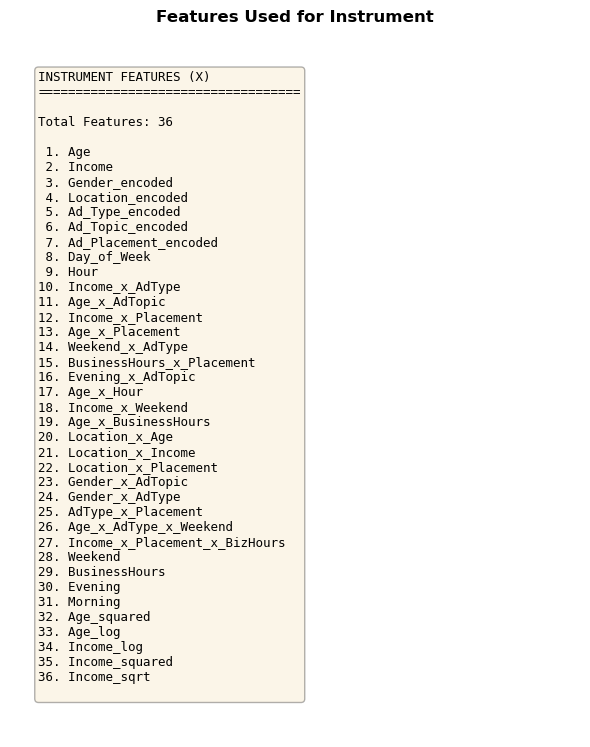

In [18]:
# Example usage in separate cells:
# Cell 1:
plot_feature_list(X)
plt.show()


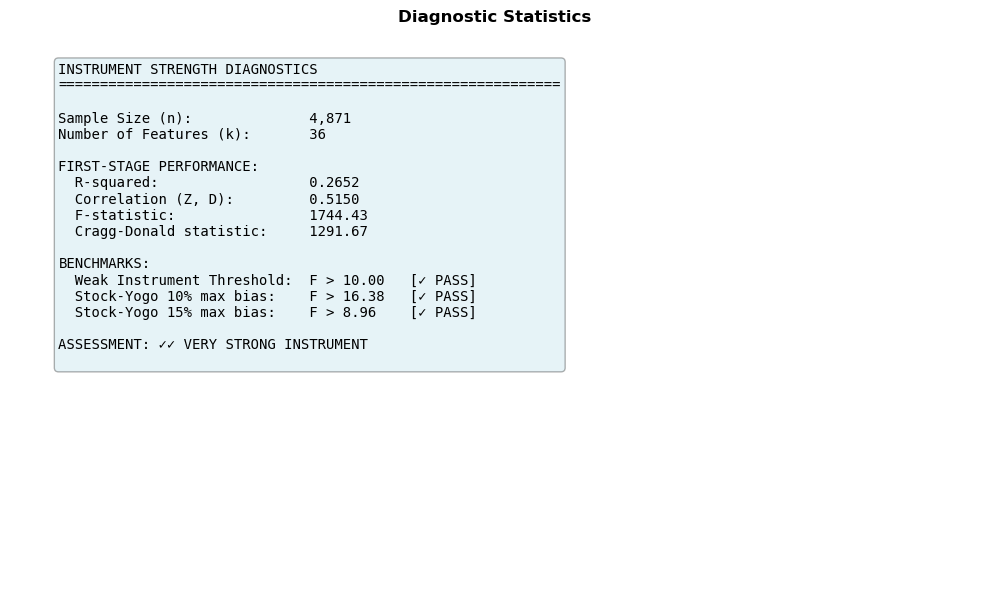

In [19]:
# Cell 2:
plot_instrument_diagnostics(df, X)
plt.show()

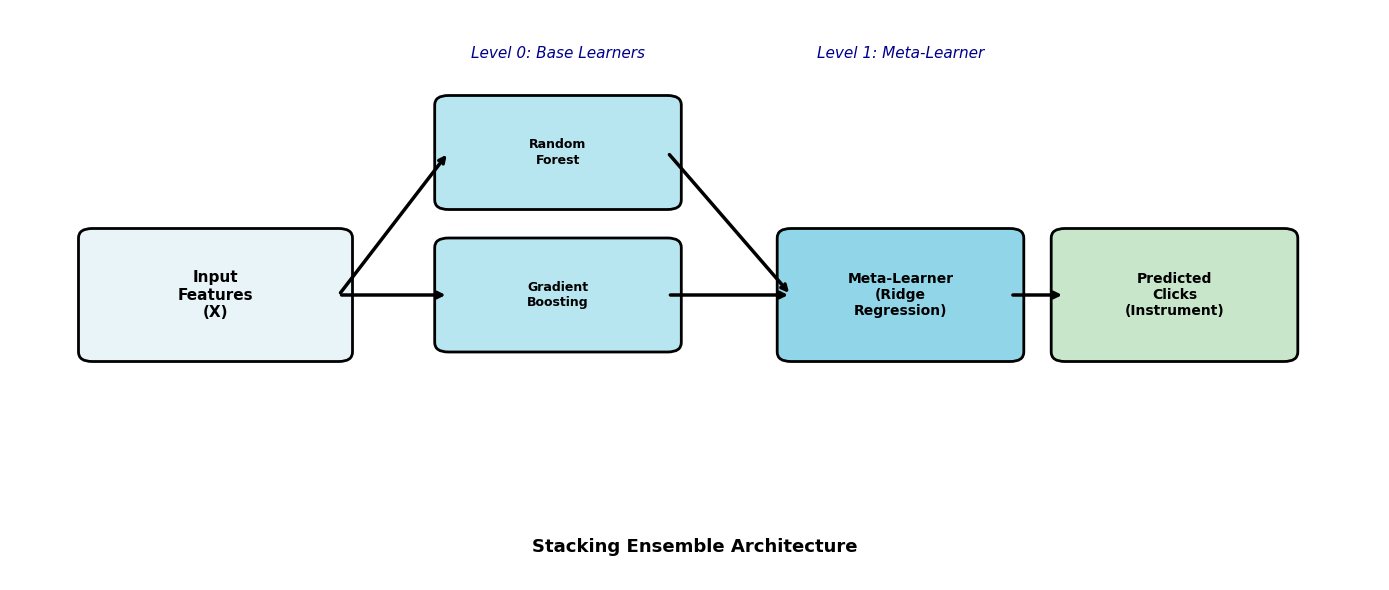

In [20]:
# Cell 3:
plot_model_pipeline(model)
plt.show()

In [21]:
# ols
controls = [
    'Age', 'Income',
    'Gender_encoded', 'Location_encoded',
    'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded'
]

results, data_used_ols = run_ols(
    df,
    y_col='Conversion_Rate',
    d_col='Clicks',
    base_controls=controls,
    # include_interactions=True,   # optional
    add_constant=True,
    cov_type='robust'            # or 'cluster' with cluster_col='CampaignID'
)


OLS ESTIMATION SUMMARY (statsmodels.api.OLS)
                            OLS Regression Results                            
Dep. Variable:        Conversion_Rate   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     1306.
Date:                Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:01:22   Log-Likelihood:                 694.40
No. Observations:                4871   AIC:                            -1371.
Df Residuals:                    4862   BIC:                            -1312.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

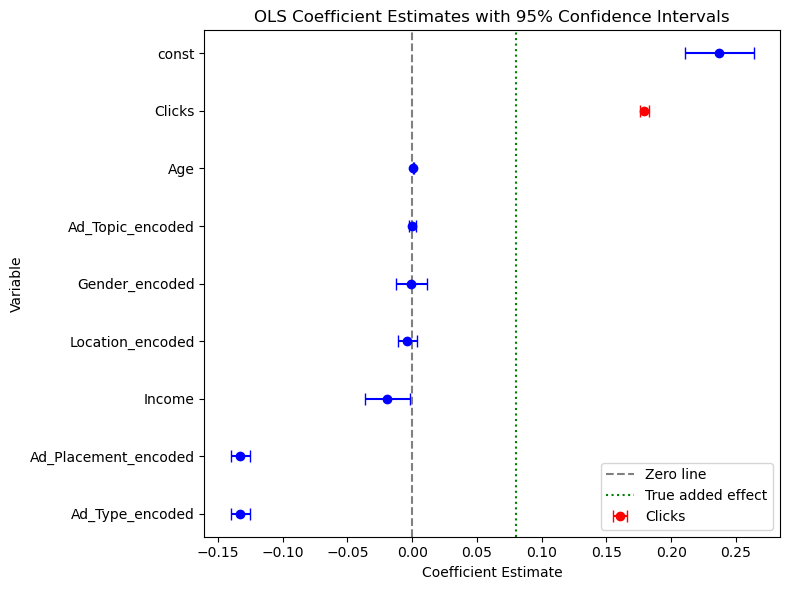

In [22]:
# Extract coefficients and confidence intervals
coef = results.params
conf = results.conf_int()
conf.columns = ['CI Lower', 'CI Upper']
pvals = results.pvalues

coef_df = pd.concat([coef, conf, pvals], axis=1).reset_index()
coef_df.columns = ['Variable', 'Coefficient', 'CI Lower', 'CI Upper', 'p-value']

# Sort for readability
coef_df = coef_df.sort_values(by='Coefficient')

# Plot with error bars
plt.figure(figsize=(8, 6))
y_positions = range(len(coef_df))

for y, row in zip(y_positions, coef_df.itertuples()):
    color = 'red' if row.Variable == 'Clicks' else 'blue'
    plt.errorbar(
        row.Coefficient, y,
        xerr=[[row.Coefficient - row._3], [row._4 - row.Coefficient]],  # CI Lower/Upper
        fmt='o', color=color, capsize=4,
        label='Clicks' if row.Variable == 'Clicks' else None
    )

# Reference lines
plt.axvline(x=0, color='gray', linestyle='--', label='Zero line')
plt.axvline(x=0.08, color='green', linestyle=':', label='True added effect')

# Labels and legend
plt.yticks(y_positions, coef_df['Variable'])
plt.title('OLS Coefficient Estimates with 95% Confidence Intervals')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Variable')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [23]:
# 2SLS with ml featured instrument
# The r-squared value is super tiny with real data for whatever reason.
# However, with my synthetic data I actually get a good r-squared score and a small p-value.
# Perhpas the move is to end the real data stuff there, but continue with Raj Chetty methodlogies with the
# synthetic data for reaserch sake.

controls = [
    'Age', 'Income',
    'Gender_encoded', 'Location_encoded',
    'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded'
]

results, data_used_2sls = run_2sls(
    df,
    y_col='Conversion_Rate',
    d_col='Clicks',
    z_col='Clicks_predicted',
    base_controls=controls,
    include_interactions=True,   # optional
    add_constant=True,
    cov_type='robust'            # or 'cluster' with cluster_col='CampaignID'
)

✓ Added exogenous interaction: Ad_Type_x_Placement

2SLS ESTIMATION SUMMARY (linearmodels.iv.IV2SLS)
                          IV-2SLS Estimation Summary                          
Dep. Variable:        Conversion_Rate   R-squared:                      0.2801
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2788
No. Observations:                4871   F-statistic:                    152.33
Date:                Sun, Nov 16 2025   P-value (F-stat)                0.0000
Time:                        20:01:23   Distribution:                  chi2(9)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------


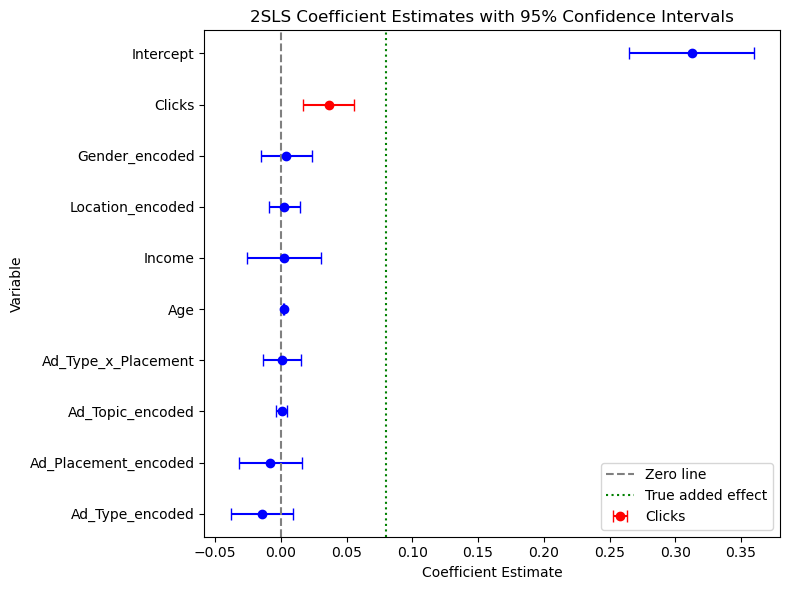

In [24]:
# Extract coefficients and confidence intervals
coef = results.params
conf = results.conf_int()
conf.columns = ['CI Lower', 'CI Upper']
pvals = results.pvalues

coef_df = pd.concat([coef, conf, pvals], axis=1).reset_index()
coef_df.columns = ['Variable', 'Coefficient', 'CI Lower', 'CI Upper', 'p-value']

# Sort for readability
coef_df = coef_df.sort_values(by='Coefficient')

# Plot with error bars
plt.figure(figsize=(8, 6))
y_positions = range(len(coef_df))

for y, row in zip(y_positions, coef_df.itertuples()):
    color = 'red' if row.Variable == 'Clicks' else 'blue'
    plt.errorbar(
        row.Coefficient, y,
        xerr=[[row.Coefficient - row._3], [row._4 - row.Coefficient]],  # CI Lower/Upper
        fmt='o', color=color, capsize=4,
        label='Clicks' if row.Variable == 'Clicks' else None
    )

# Reference lines
plt.axvline(x=0, color='gray', linestyle='--', label='Zero line')
plt.axvline(x=0.08, color='green', linestyle=':', label='True added effect')

# Labels and legend
plt.yticks(y_positions, coef_df['Variable'])
plt.title('2SLS Coefficient Estimates with 95% Confidence Intervals')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Variable')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


##### End of Implementation

##### Raj Chetty Start

In [25]:
# good spot to make sure indecies are lined up before we merge predictions of ols and 2sls onto the og dataaset.
print('BEFORE\n')
print('data_used_ols\n ', data_used_ols.head(5))
print('\ndata_used_2sls\n ', data_used_2sls.head(5))
print('\ndf\n ', df.head(5))


# Merge predictions back into the original df by index
df_combined = df.copy()
df_combined = df_combined.join(data_used_ols[['CR_pred_OLS']], how='left')
df_combined = df_combined.join(data_used_2sls[['CR_pred_2SLS']], how='left')

print('AFTER\n')
print('\df_combined\n ', df_combined.head(5))
df_combined.shape

BEFORE

data_used_ols
     Conversion_Rate    Clicks  Age   Income  Gender_encoded  Location_encoded  \
0         0.010000  0.100000   59  0.84412               1                 0   
1         0.785039  3.383052   22  0.90561               0                 0   
2         0.643625  1.304174   79  1.07224               1                 1   
3         0.950000  2.816561   68  0.34409               0                 0   
4         0.136113  2.363033   28  1.01319               1                 1   

   Ad_Type_encoded  Ad_Topic_encoded  Ad_Placement_encoded  CR_pred_OLS  
0                0                 7                     1     0.154372  
1                2                 4                     1     0.445914  
2                1                 0                     1     0.244915  
3                1                 7                     0     0.658231  
4                2                 0                     1     0.261375  

data_used_2sls
     Conversion_Rate    Clicks  Cli

(4871, 48)

In [26]:
# Define cohorts by Ad_Type × Ad_Placement
df_combined['Cohort'] = df_combined['Ad_Type'] + '_' + df_combined['Ad_Placement']

# Aggregate actual and predicted conversion rates by cohort
group_summary = df_combined.groupby('Cohort').agg({
    'Conversion_Rate': 'mean',
    'CR_pred_OLS': 'mean',
    'CR_pred_2SLS': 'mean',
    'Clicks': 'mean'
}).reset_index()

# Compute forecast bias
group_summary['Bias_OLS'] = group_summary['CR_pred_OLS'] - group_summary['Conversion_Rate']
group_summary['Bias_2SLS'] = group_summary['CR_pred_2SLS'] - group_summary['Conversion_Rate']



In [45]:
import matplotlib.pyplot as plt

def plot_cohort_list(df, title="Cohorts Used", figsize=(6, 8)):
    """
    Display list of cohorts in a text panel, similar to plot_feature_list.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain a 'Cohort' column
    title : str
        Title for the plot
    figsize : tuple
        Figure size (width, height)
    """
    cohorts = sorted(df['Cohort'].unique())
    k = len(cohorts)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    
    cohort_text = f"{title}\n" + "="*35 + "\n\n"
    cohort_text += f"Total Cohorts: {k}\n\n"
    
    for i, c in enumerate(cohorts, 1):
        cohort_text += f"{i:2d}. {c}\n"
    
    ax.text(0.05, 0.95, cohort_text,
             transform=ax.transAxes,
             fontsize=9,
             verticalalignment='top',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    
    plt.tight_layout()
    return fig


['Banner_Display' 'Banner_Search' 'Banner_Social_Media' 'Native_Display'
 'Native_Search' 'Native_Social_Media' 'Video_Display' 'Video_Search'
 'Video_Social_Media']
Number of cohorts: 9


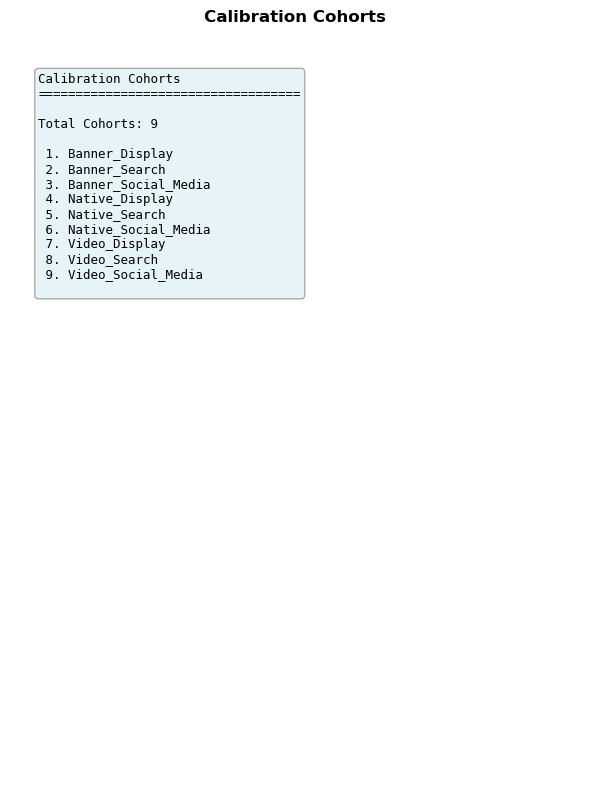

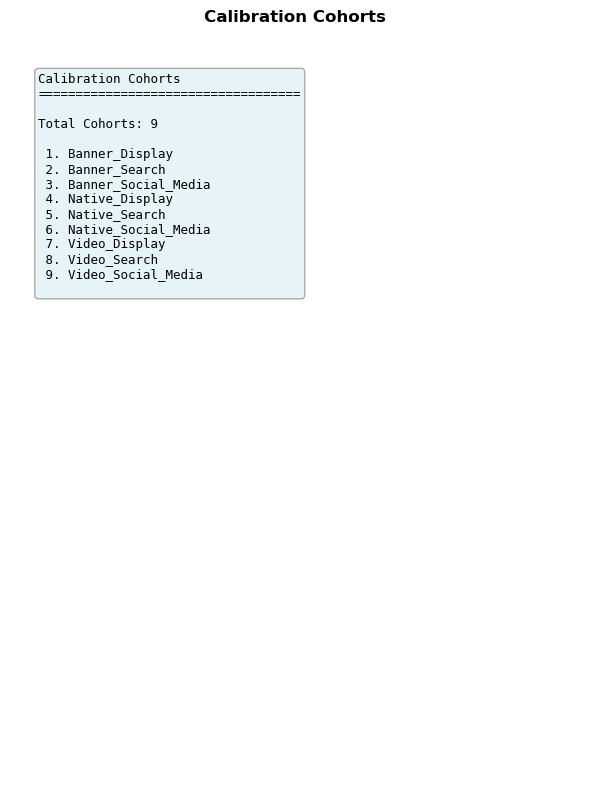

In [44]:
print(group_summary['Cohort'].unique())
print("Number of cohorts:", group_summary['Cohort'].nunique())

plot_cohort_list(group_summary, title="Calibration Cohorts")


In [27]:

# OLS calibration: actual ~ predicted (OLS)
X_ols = sm.add_constant(group_summary['CR_pred_OLS'])
y_ols = group_summary['Conversion_Rate']
calib_ols = sm.OLS(y_ols, X_ols).fit()

# 2SLS calibration: actual ~ predicted (2SLS)
X_2sls = sm.add_constant(group_summary['CR_pred_2SLS'])
y_2sls = group_summary['Conversion_Rate']
calib_2sls = sm.OLS(y_2sls, X_2sls).fit()

# Print calibration slopes
print("Calibration slope (OLS):", calib_ols.params[1])
print("Calibration slope (2SLS):", calib_2sls.params[1])


Calibration slope (OLS): 0.282660898560962
Calibration slope (2SLS): 1.0955770105072722


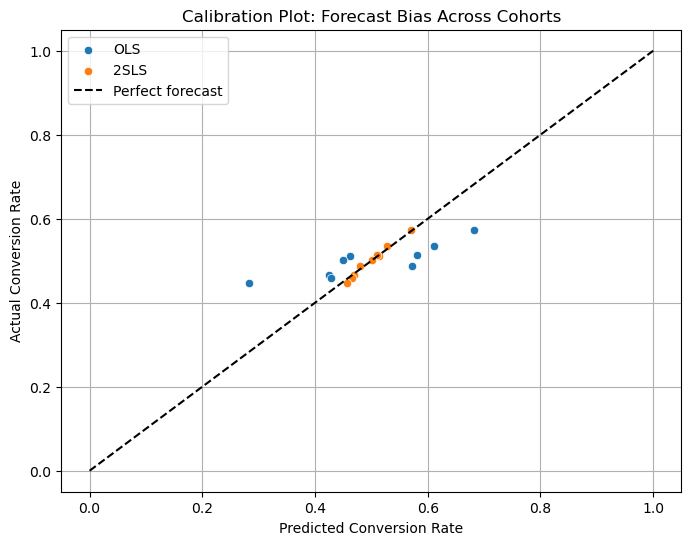

In [28]:
# Calibration plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='CR_pred_OLS', y='Conversion_Rate', data=group_summary, label='OLS')
sns.scatterplot(x='CR_pred_2SLS', y='Conversion_Rate', data=group_summary, label='2SLS')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect forecast')
plt.xlabel('Predicted Conversion Rate')
plt.ylabel('Actual Conversion Rate')
plt.title('Calibration Plot: Forecast Bias Across Cohorts')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

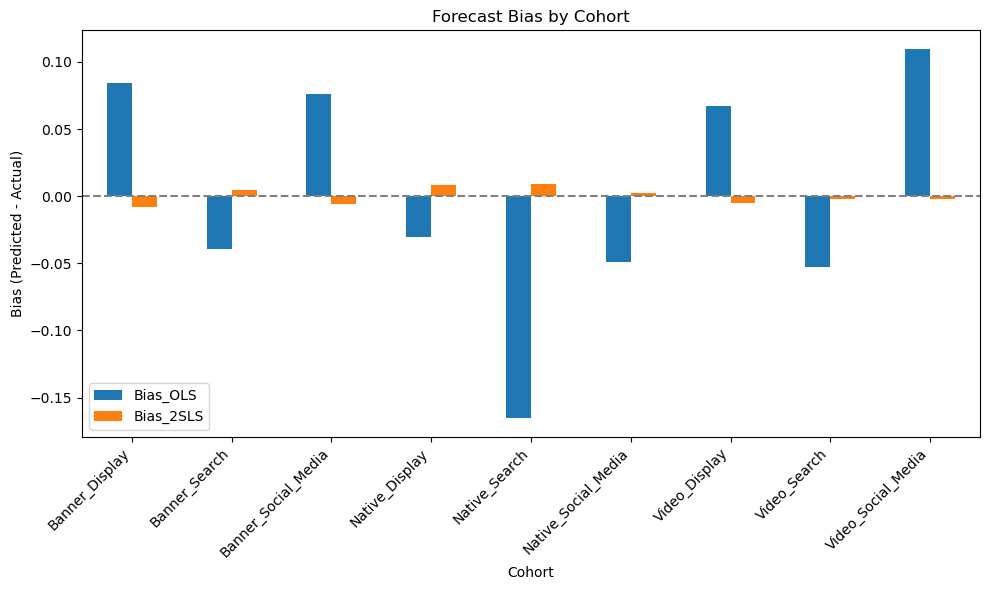

In [29]:
plt.figure(figsize=(10,6))
group_summary.plot(
    x='Cohort', y=['Bias_OLS','Bias_2SLS'],
    kind='bar', figsize=(10,6)
)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Forecast Bias by Cohort')
plt.ylabel('Bias (Predicted - Actual)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [32]:
# Event style validation 
# Example: simulate a shock by changing Ad_Type for half the sample
df_event = df_combined.copy()
mask = df_event['Ad_Type'] == 'Banner'
df_event.loc[mask, 'Ad_Type'] = 'Video'
df_event['Cohort'] = df_event['Ad_Type'] + '_' + df_event['Ad_Placement']

In [33]:
# Forecasted mean conversion rates by cohort
forecast_summary = df_event.groupby('Cohort').agg({
    'CR_pred_OLS': 'mean',
    'CR_pred_2SLS': 'mean'
}).reset_index()

In [34]:
actual_summary = df_event.groupby('Cohort')['Conversion_Rate'].mean().reset_index()

In [35]:
event_comparison = forecast_summary.merge(actual_summary, on='Cohort')
event_comparison['ForecastBias_OLS'] = event_comparison['CR_pred_OLS'] - event_comparison['Conversion_Rate']
event_comparison['ForecastBias_2SLS'] = event_comparison['CR_pred_2SLS'] - event_comparison['Conversion_Rate']

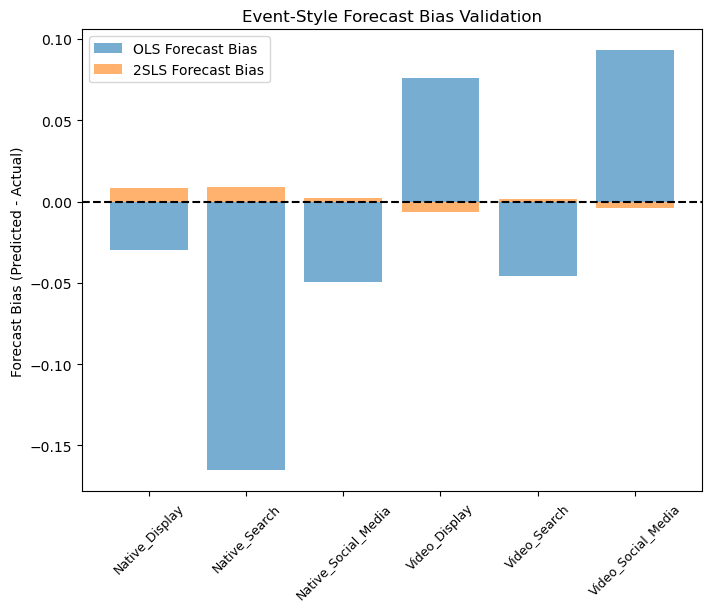

In [36]:
plt.figure(figsize=(8,6))
plt.bar(event_comparison['Cohort'], event_comparison['ForecastBias_OLS'], alpha=0.6, label='OLS Forecast Bias')
plt.bar(event_comparison['Cohort'], event_comparison['ForecastBias_2SLS'], alpha=0.6, label='2SLS Forecast Bias')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Forecast Bias (Predicted - Actual)')
plt.title('Event-Style Forecast Bias Validation')
plt.xticks(rotation=45, fontsize=9)  # Rotate labels and shrink font size
plt.legend()
plt.show()

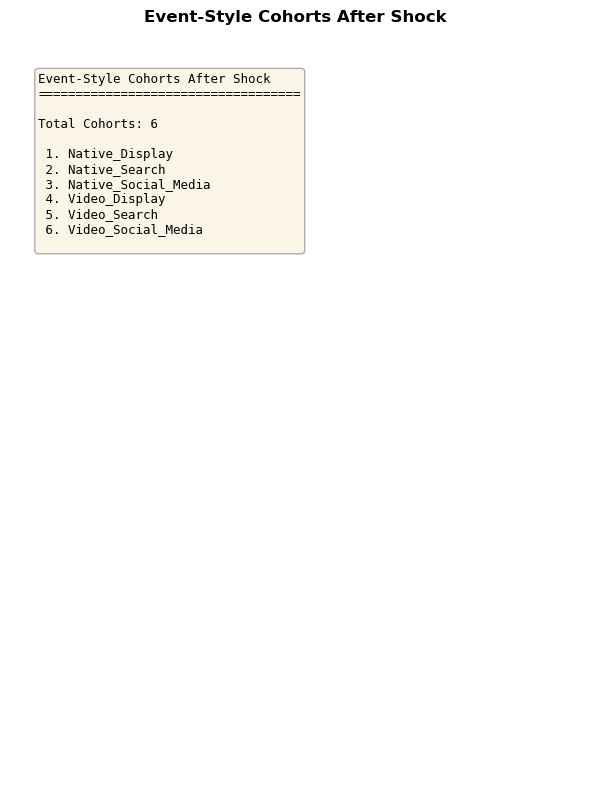

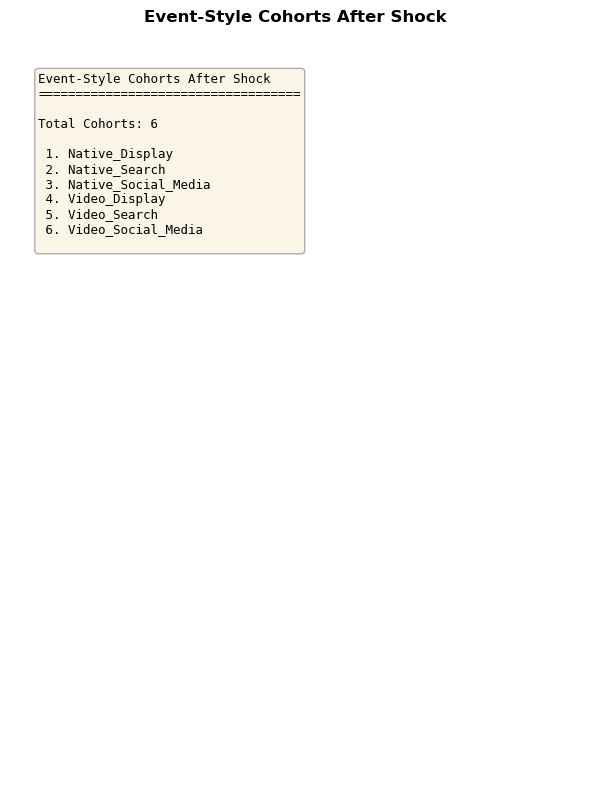

In [46]:
plot_cohort_list(event_comparison, title="Event-Style Cohorts After Shock")

##### Raj Chetty End

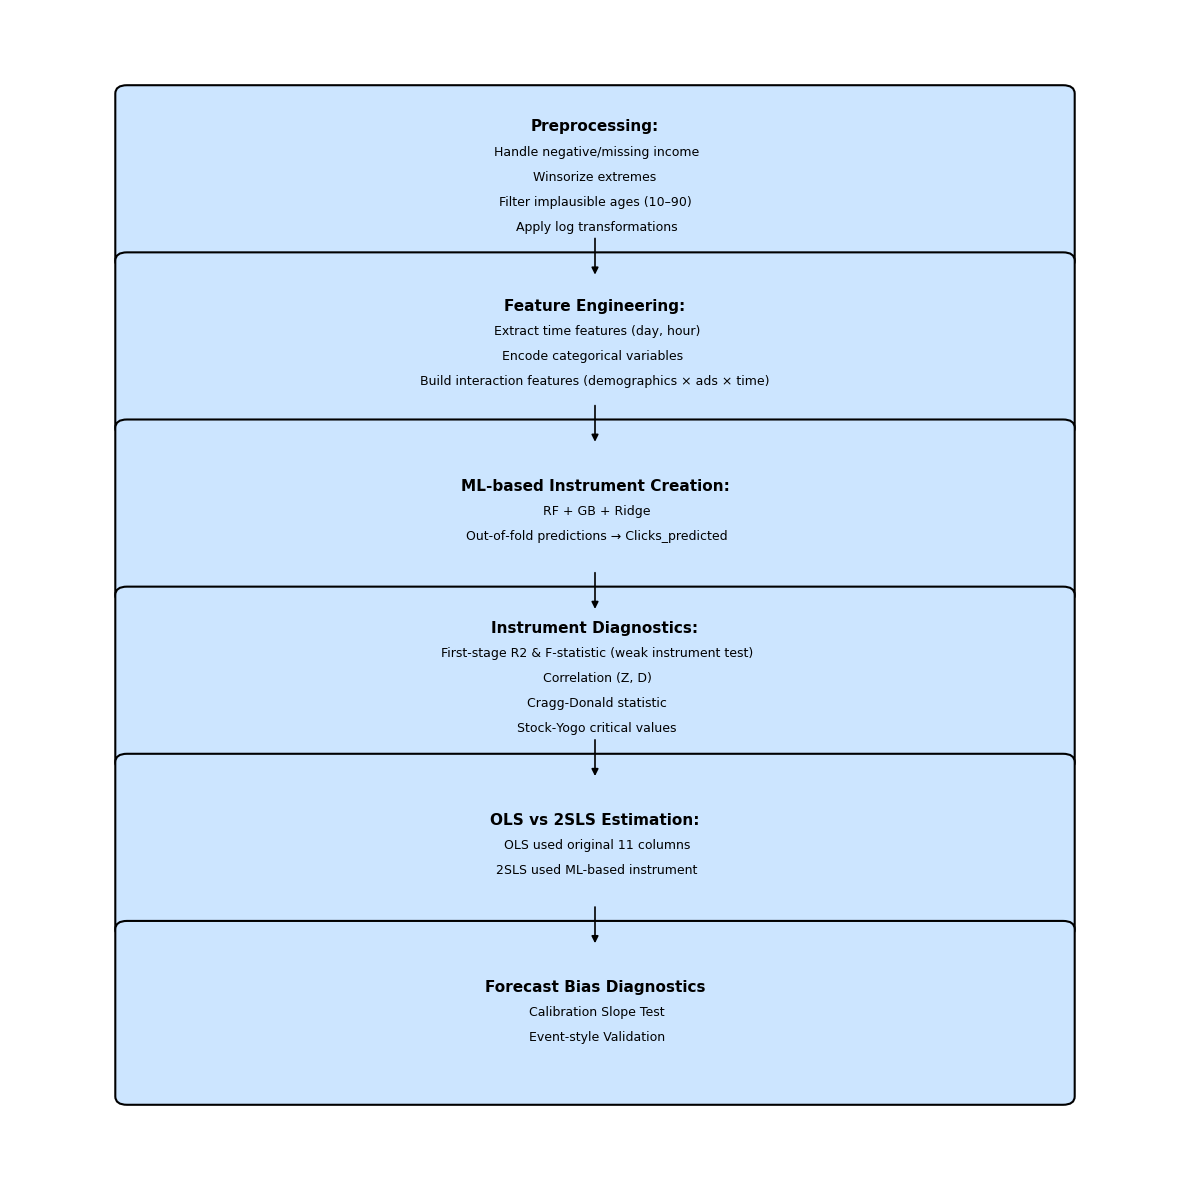

In [37]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

steps = [
    "Preprocessing:\n Handle negative/missing income\n Winsorize extremes \nFilter implausible ages (10–90)\n Apply log transformations",
    "Feature Engineering:\n Extract time features (day, hour)\nEncode categorical variables \nBuild interaction features (demographics × ads × time)",
    "ML-based Instrument Creation:\n RF + GB + Ridge\n Out‑of‑fold predictions → Clicks_predicted",
    "Instrument Diagnostics:\n First‑stage R2 & F‑statistic (weak instrument test)\n Correlation (Z, D)\n Cragg‑Donald statistic\n Stock‑Yogo critical values",
    "OLS vs 2SLS Estimation:\n OLS used original 11 columns\n 2SLS used ML-based instrument",
    "Forecast Bias Diagnostics\n Calibration Slope Test\n Event-style Validation"
]

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(0, 10)
ax.set_ylim(0, len(steps) * 2 + 2)
ax.axis('off')

def draw_box(ax, text, center, width=8, height=1.2):
    x, y = center
    box = FancyBboxPatch(
        (x - width/2, y - height/2), width, height,
        boxstyle="round,pad=0.1", edgecolor="black",
        facecolor="#cce5ff", linewidth=1.5
    )
    ax.add_patch(box)
    
    # Split into lines
    lines = text.split("\n")
    # Adjust vertical spacing
    line_spacing = 0.3
    start_y = y + (line_spacing * (len(lines)-1)/2)
    
    for j, line in enumerate(lines):
        if j == 0:
            # First line bigger and bold
            ax.text(x, start_y - j*line_spacing, line,
                    ha='center', va='center', fontsize=11, weight='bold')
        else:
            # Subsequent lines smaller
            ax.text(x, start_y - j*line_spacing, line,
                    ha='center', va='center', fontsize=9)

spacing = 3.0   # adjust this number to control space between boxes
y_positions = [(len(steps) - i) * spacing for i in range(len(steps))]

# Draw boxes and arrows
for i, step in enumerate(steps):
    y = (len(steps) - i) * 2
    draw_box(ax, step, center=(5, y), height=2)  # taller boxes for multiline text
    if i < len(steps) - 1:
        ax.annotate(
            '', 
            xy=(5, y - 1.2),   # tip (below current box)
            xytext=(5, y - 0.7),  # tail (just under box, higher than tip)
            arrowprops=dict(arrowstyle='-|>', lw=1.2, color='black')
        )

plt.tight_layout()
plt.show()


ML techniques build strong instruments when predictors are reliable.

In OLS vs 2SLS, endogeneity is corrected by 2SLS.

Chetty-style cohorts and shocks confirm 2SLS robustness over OLS.

Generated vertical poster-style image with bold conclusion points and saved as conclusion_poster.png


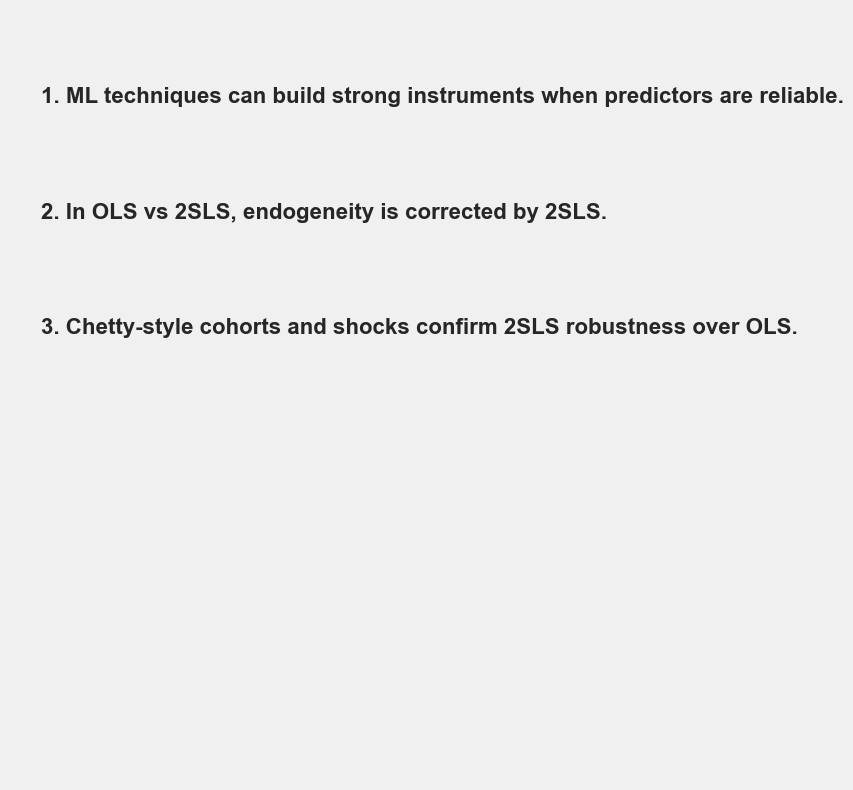

In [ ]:
# Creating poster-style image with bold, left-aligned text on solid background
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 10))
fig.patch.set_facecolor('#f0f0f0')  # Light gray background
ax.set_facecolor('#f0f0f0')
ax.axis('off')

# Text content
points = [
    "1. ML techniques can build strong instruments when predictors are reliable.",
    "2. In OLS vs 2SLS, endogeneity is corrected by 2SLS.",
    "3. Chetty-style cohorts and shocks confirm 2SLS robustness over OLS."
]

# Font settings
fontdict = {
    'fontsize': 16,
    'fontweight': 'bold',
    'verticalalignment': 'top',
    'horizontalalignment': 'left',
    'family': 'sans-serif'
}

# Positioning
x = 0.05
y_start = 0.9
line_spacing = 0.15

for i, point in enumerate(points):
    y = y_start - i * line_spacing
    ax.text(x, y, point, fontdict=fontdict, transform=ax.transAxes)
